# Project 4: Clasificación de Imágenes — CIFAR-10

**CS3061 — Machine Learning | UTEC 2026-0**

---

## Integrantes
- **Ladera La Torre, Fabricio Godofredo**
- **Velo Poma, Juan David**
- **Huapaya Nuñez, Luis Felipe Augusto**
- **Montalvo Anaya, Diego Andres**

---

## Descripción del Proyecto

El dataset **CIFAR-10** (Canadian Institute for Advanced Research) es uno de los benchmarks más utilizados en visión por computadora. Contiene **60,000 imágenes a color** de $32 \times 32$ píxeles, distribuidas en **10 clases** mutuamente excluyentes: `airplane`, `automobile`, `bird`, `cat`, `deer`, `dog`, `frog`, `horse`, `ship` y `truck`.

A diferencia de datasets como MNIST (dígitos en escala de grises), CIFAR-10 presenta desafíos significativos: las imágenes son **a color** (3 canales RGB), tienen **baja resolución**, presentan **variabilidad intra-clase** elevada, y algunas clases son visualmente similares (e.g., `cat` vs `dog`, `automobile` vs `truck`).

### Objetivos
1. **Comparar 5 arquitecturas CNN** de complejidad creciente para clasificar imágenes CIFAR-10.
2. **Evaluar el impacto de Data Augmentation** en la generalización del modelo.
3. **Analizar la duplicación de capas convolucionales** por bloque en la capacidad de representación.
4. **Estudiar el efecto del Learning Rate Scheduling** en la convergencia.
5. **Implementar DenseNet-BC**, una arquitectura avanzada con conexiones densas, bottleneck y compresión.
6. **Evaluar con múltiples métricas** (Accuracy, Precision, Recall, F1-Score, Matrices de Confusión).

### Estructura del Notebook
1. Marco Teórico (Convolución, Pooling, Softmax, Cross-Entropy, Backpropagation)
2. Importación de Librerías
3. Carga y Exploración del Dataset CIFAR-10
4. Preprocesamiento
5. Modelo 1 — CNN Básica (30 epochs)
6. Modelo 2 — CNN + Data Augmentation (30 epochs)
7. Modelo 3 — CNN Doble Conv + Augmentation (30 epochs)
8. Modelo 4 — CNN Doble Conv + LR Scheduler (30 epochs)
9. Modelo 5 — DenseNet-BC (30 epochs)
10. Evaluación Completa (Precision, Recall, F1, Matrices de Confusión)
11. Análisis Comparativo: Curvas, Parámetros vs. Performance
12. Análisis Avanzado: Visualización de Kernels y Predicciones
13. Conclusiones

## 1. Marco Teórico

### 1.1 Operación de Convolución

La **convolución** es la operación fundamental de las CNNs. Matemáticamente, la convolución discreta 2D entre una imagen $I$ y un kernel (filtro) $K$ de tamaño $k \times k$ se define como:

$$
(I * K)[i, j] = \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} I[i + m, \, j + n] \cdot K[m, n]
$$

El kernel se desliza sobre la imagen con un paso (**stride**) $S$, y el tamaño de salida del mapa de características es:

$$
\text{Output size} = \frac{N - K + 2P}{S} + 1
$$

donde $N$ es el tamaño de la entrada, $K$ el tamaño del kernel y $P$ el padding (relleno con ceros).

**Ventajas clave de la convolución frente a capas densas:**
- **Compartición de pesos** (*parameter sharing*): El mismo kernel se aplica en toda la imagen, reduciendo drásticamente el número de parámetros.
- **Conectividad local** (*sparse connectivity*): Cada neurona solo depende de una región local de la entrada, capturando patrones espaciales jerárquicos.
- **Invariancia a traslación**: Un patrón detectado en una región puede ser reconocido en otra posición.

### 1.2 Pooling (Submuestreo)

La operación de **Max-Pooling** reduce las dimensiones espaciales del mapa de características, conservando las activaciones más relevantes:

$$
\text{MaxPool}(X)[i, j] = \max_{(m, n) \in \mathcal{R}_{ij}} X[m, n]
$$

donde $\mathcal{R}_{ij}$ es la región (ventana) de pooling centrada en $(i, j)$.

**Beneficios:**
- Reduce carga computacional y número de parámetros
- Controla el sobreajuste
- Proporciona cierta invariancia a traslaciones pequeñas

### 1.3 Batch Normalization

La **normalización por lotes** normaliza las activaciones de cada capa para estabilizar y acelerar el entrenamiento:

$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}, \quad y_i = \gamma \hat{x}_i + \beta
$$

donde $\mu_B$ y $\sigma_B^2$ son la media y varianza del mini-batch, y $\gamma$, $\beta$ son parámetros aprendibles. Esto permite usar tasas de aprendizaje más altas y reduce la sensibilidad a la inicialización.

### 1.4 Función de Activación Softmax

Para clasificación multiclase, la capa de salida utiliza **Softmax**, que transforma un vector de logits $z \in \mathbb{R}^{C}$ (donde $C$ es el número de clases) en una distribución de probabilidad:

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}, \quad i = 1, \dots, C
$$

**Propiedades:**
- $\sum_{i=1}^{C} \text{Softmax}(z_i) = 1$ (suma a 1)
- $\text{Softmax}(z_i) > 0 \quad \forall i$ (valores positivos)
- Es un caso generalizado de la función sigmoide para más de 2 clases

### 1.5 Función de Pérdida: Cross-Entropy

La **Sparse Categorical Cross-Entropy** mide la divergencia entre la distribución predicha $\hat{y}$ y la clase verdadera $c$:

$$
\mathcal{L}_{\text{CE}} = -\log(\hat{y}_c)
$$

Para un batch de $N$ muestras:

$$
\mathcal{L} = -\frac{1}{N} \sum_{n=1}^{N} \log(\hat{y}_{c^{(n)}}^{(n)})
$$

**Intuición:** La Cross-Entropy penaliza fuertemente las predicciones confiadas pero incorrectas. Si el modelo predice $\hat{y}_c \approx 0$ para la clase verdadera, el término $-\log(\hat{y}_c) \to \infty$, generando un gradiente grande que fuerza al modelo a corregirse.

### 1.6 Backpropagation y Regla de la Cadena

El entrenamiento de redes neuronales se basa en la **propagación hacia atrás** (Backpropagation), que calcula el gradiente de la función de pérdida respecto a cada peso usando la **regla de la cadena**:

$$
\frac{\partial \mathcal{L}}{\partial w_{ij}^{(l)}} = \frac{\partial \mathcal{L}}{\partial a_j^{(l)}} \cdot \frac{\partial a_j^{(l)}}{\partial z_j^{(l)}} \cdot \frac{\partial z_j^{(l)}}{\partial w_{ij}^{(l)}}
$$

donde $z_j^{(l)}$ es la pre-activación y $a_j^{(l)}$ la activación de la neurona $j$ en la capa $l$. Este mecanismo permite actualizar los pesos en la dirección que minimiza la pérdida:

$$
w \leftarrow w - \eta \cdot \frac{\partial \mathcal{L}}{\partial w}
$$

con $\eta$ siendo la tasa de aprendizaje (*learning rate*).

### 1.7 Data Augmentation

La **aumentación de datos** genera variaciones sintéticas de las imágenes de entrenamiento (rotaciones, desplazamientos, flips), lo que:
- **Aumenta efectivamente** el tamaño del dataset de entrenamiento
- **Reduce el sobreajuste** al exponer al modelo a más variabilidad
- **Mejora la generalización** sin necesidad de recopilar más datos

### 1.8 DenseNet — Conexiones Densas

En una arquitectura **DenseNet** (Huang et al., 2017), cada capa recibe como entrada la concatenación de los feature maps de **todas las capas anteriores** dentro del mismo bloque:

$$
x_l = H_l([x_0, x_1, \dots, x_{l-1}])
$$

**Ventajas:**
- **Mejora el flujo de gradientes** durante backpropagation
- **Incentiva la reutilización de features** entre capas
- **Reduce el número de parámetros** gracias al bottleneck (Conv 1×1) y compression ($\theta = 0.5$)

## 2. Importación de Librerías

Se importan todas las librerías necesarias: TensorFlow/Keras para redes neuronales, scikit-learn para métricas de evaluación, seaborn para visualizaciones avanzadas y pandas para tablas.

In [ ]:
# ============================================================
# 2. IMPORTACIÓN DE LIBRERÍAS
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Deep Learning — TensorFlow / Keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D,
                          GlobalAveragePooling2D, Flatten, Dense,
                          Dropout, BatchNormalization, Activation,
                          Input, Concatenate)
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Métricas de Clasificación
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
warnings.filterwarnings('ignore')

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Información del entorno
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")
print(f"Todas las librerías importadas correctamente.")

TensorFlow version: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Todas las librerías importadas correctamente.


## 3. Carga y Exploración del Dataset CIFAR-10

CIFAR-10 se carga directamente desde `tensorflow.keras.datasets`. El dataset contiene 60,000 imágenes de $32 \times 32 \times 3$ (RGB) distribuidas en 10 clases con 6,000 imágenes por clase.

In [ ]:
# ============================================================
# 3.1 CARGA DEL DATASET CIFAR-10
# ============================================================

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("=" * 60)
print("DATASET CIFAR-10 — INFORMACIÓN GENERAL")
print("=" * 60)
print(f"\nEntrenamiento: {x_train.shape[0]:,} imágenes")
print(f"Test:          {x_test.shape[0]:,} imágenes")
print(f"Dimensiones:   {x_train.shape[1:]} (alto × ancho × canales)")
print(f"Clases:        {len(class_names)} → {class_names}")
print(f"Rango píxeles: [{x_train.min()}, {x_train.max()}]")
print(f"Tipo de datos:  {x_train.dtype}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
DATASET CIFAR-10 — INFORMACIÓN GENERAL

Entrenamiento: 50,000 imágenes
Test:          10,000 imágenes
Dimensiones:   (32, 32, 3) (alto × ancho × canales)
Clases:        10 → ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Rango píxeles: [0, 255]
Tipo de datos:  uint8


### 3.2 Distribución de Clases

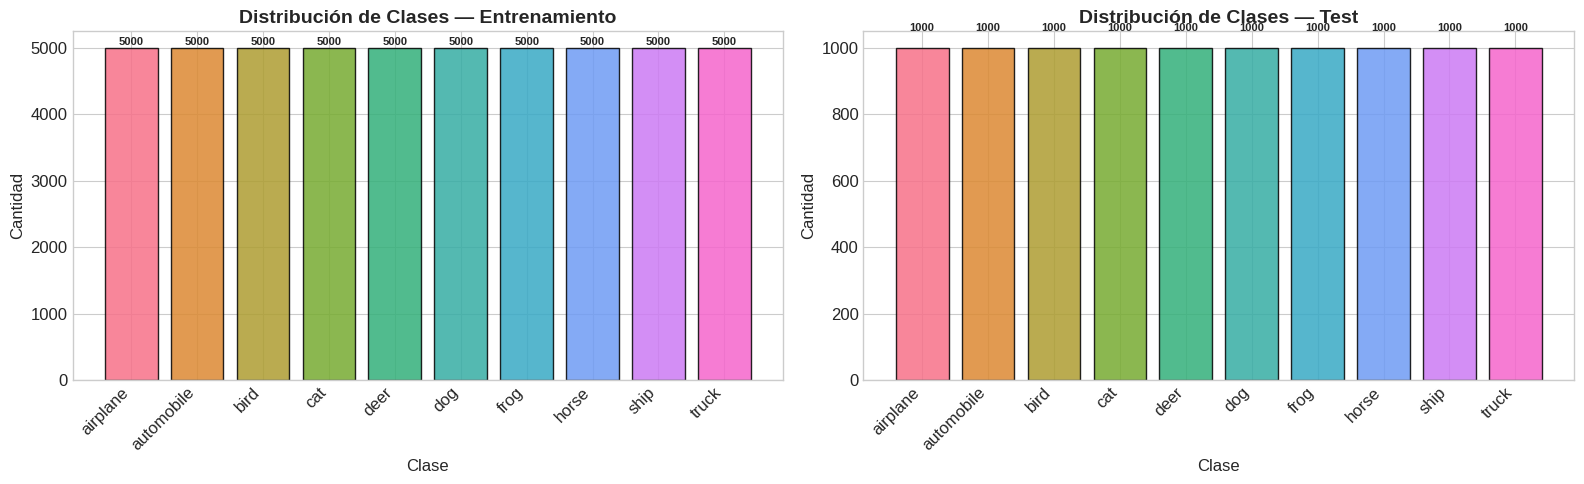

Dataset perfectamente balanceado: 5,000 imágenes/clase (train)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
colors = sns.color_palette("husl", 10)

for ax, data, title in [(axes[0], y_train, 'Entrenamiento'), (axes[1], y_test, 'Test')]:
    classes, counts = np.unique(data, return_counts=True)
    bars = ax.bar(classes, counts, color=colors, edgecolor='black', alpha=0.85)
    ax.set_title(f'Distribución de Clases — {title}', fontweight='bold')
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_xticks(range(10))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
                str(count), ha='center', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()
print(f"Dataset perfectamente balanceado: {np.unique(y_train, return_counts=True)[1][0]:,} imágenes/clase (train)")

### 3.3 Muestras por Clase

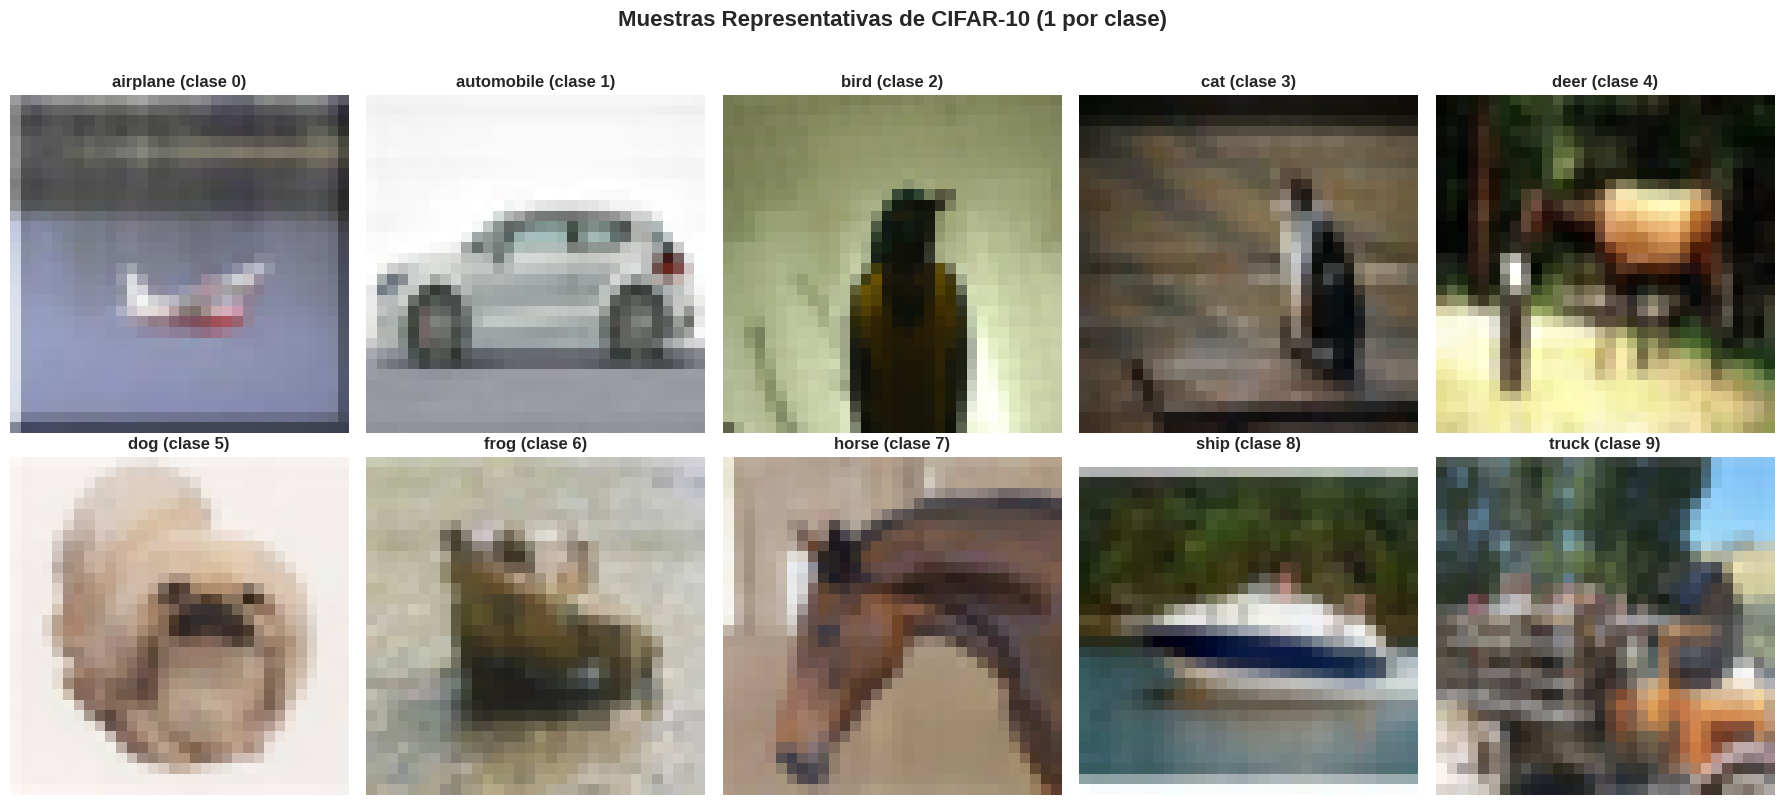

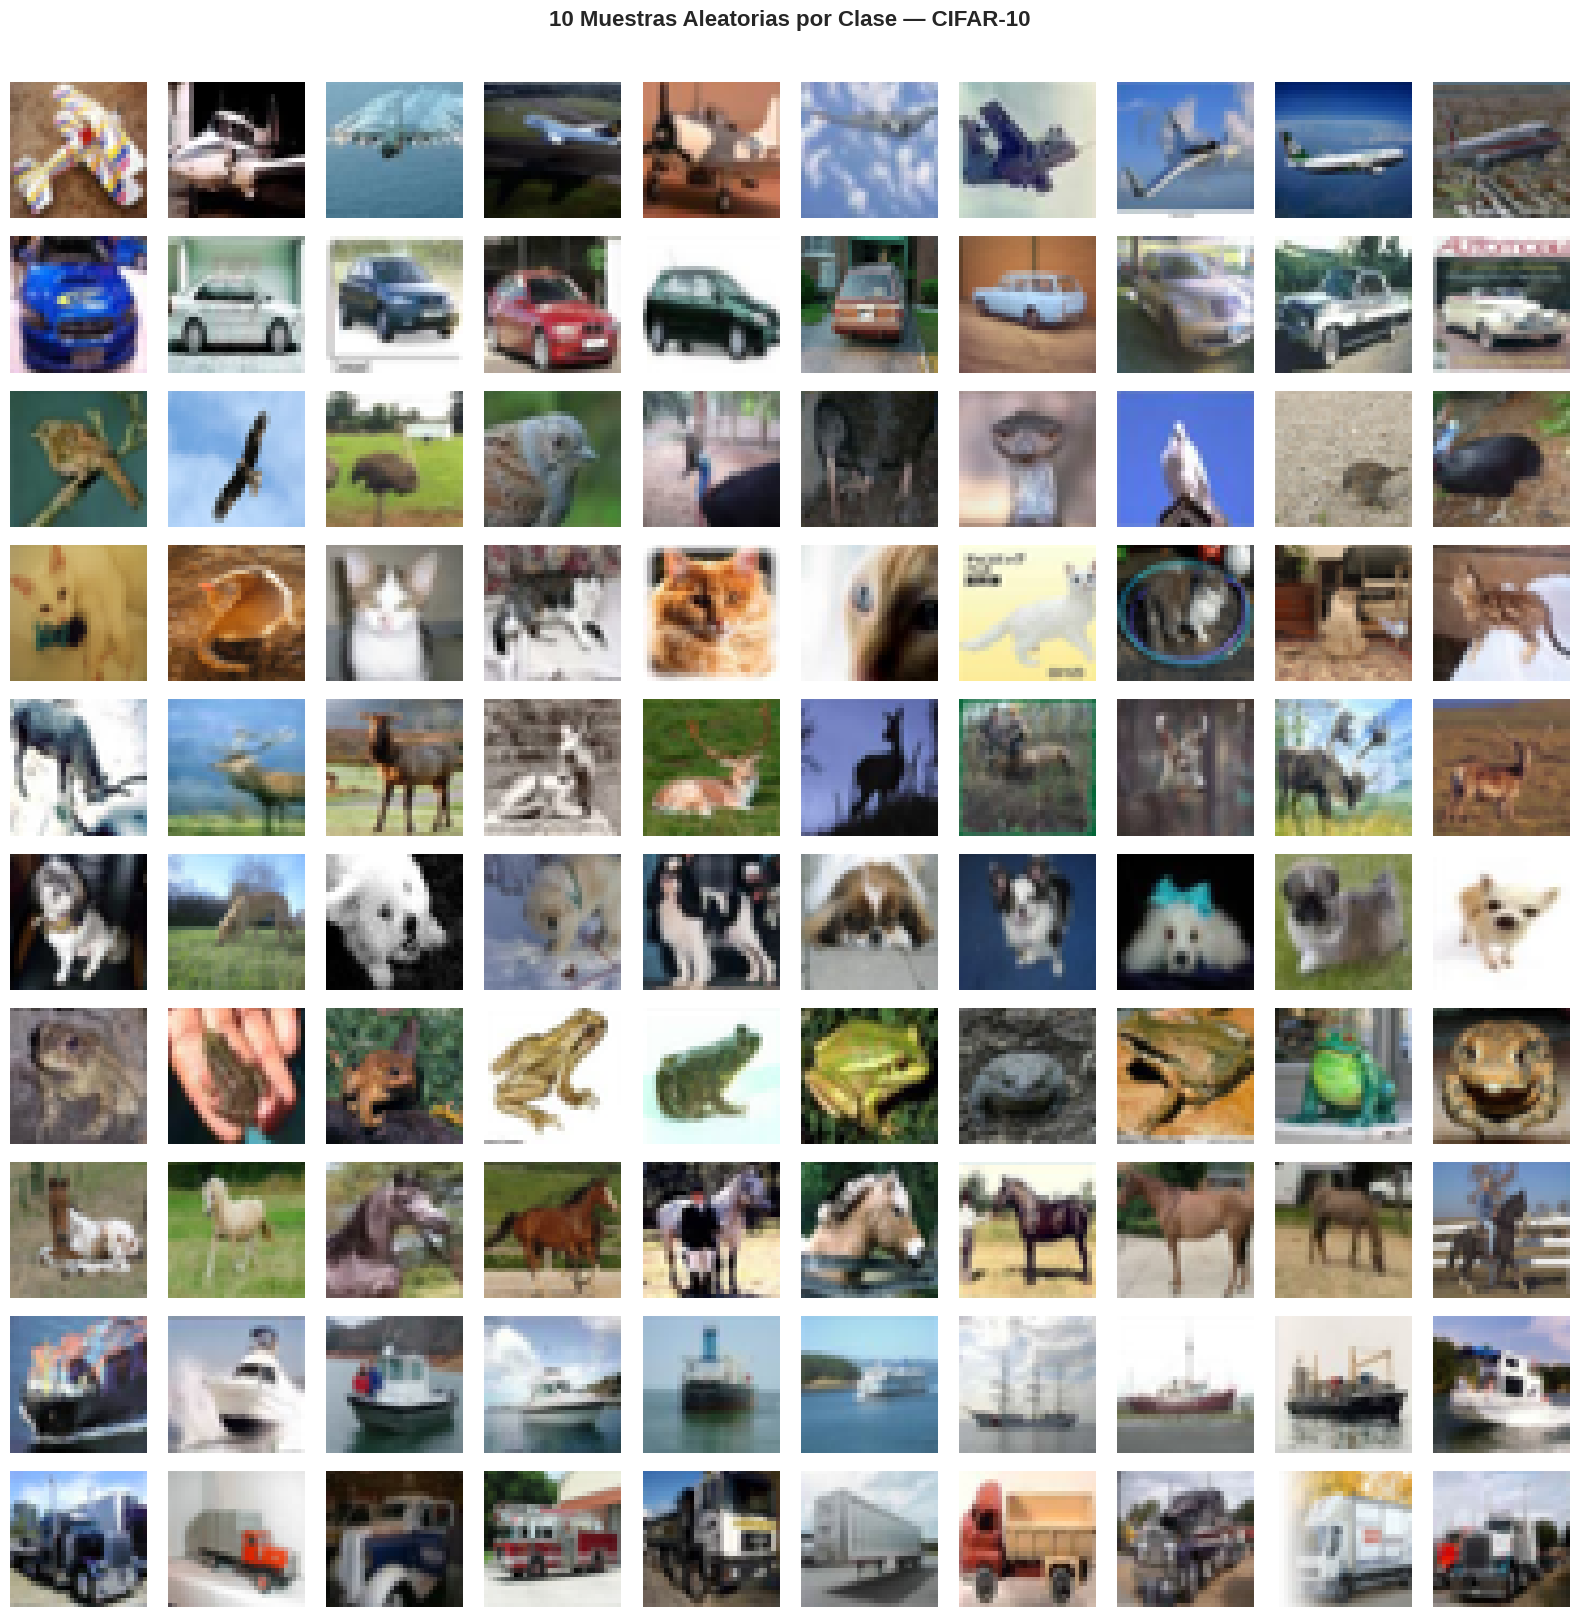

In [ ]:
# Una imagen representativa por clase
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for i, class_name in enumerate(class_names):
    idx = np.where(y_train == i)[0]
    sample_idx = np.random.choice(idx)
    axes[i].imshow(x_train[sample_idx])
    axes[i].set_title(f'{class_name} (clase {i})', fontweight='bold', fontsize=12)
    axes[i].axis('off')

plt.suptitle('Muestras Representativas de CIFAR-10 (1 por clase)', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Grilla 10x10 de imágenes aleatorias
fig, axes = plt.subplots(10, 10, figsize=(16, 16))
for i in range(10):
    idx_class = np.where(y_train == i)[0]
    samples = np.random.choice(idx_class, 10, replace=False)
    for j, sample_idx in enumerate(samples):
        axes[i][j].imshow(x_train[sample_idx])
        axes[i][j].axis('off')
        if j == 0:
            axes[i][j].set_ylabel(class_names[i], fontsize=10, fontweight='bold',
                                   rotation=0, labelpad=60)

plt.suptitle('10 Muestras Aleatorias por Clase — CIFAR-10', fontweight='bold', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

### 3.4 Distribución de Intensidad de Píxeles y Análisis RGB

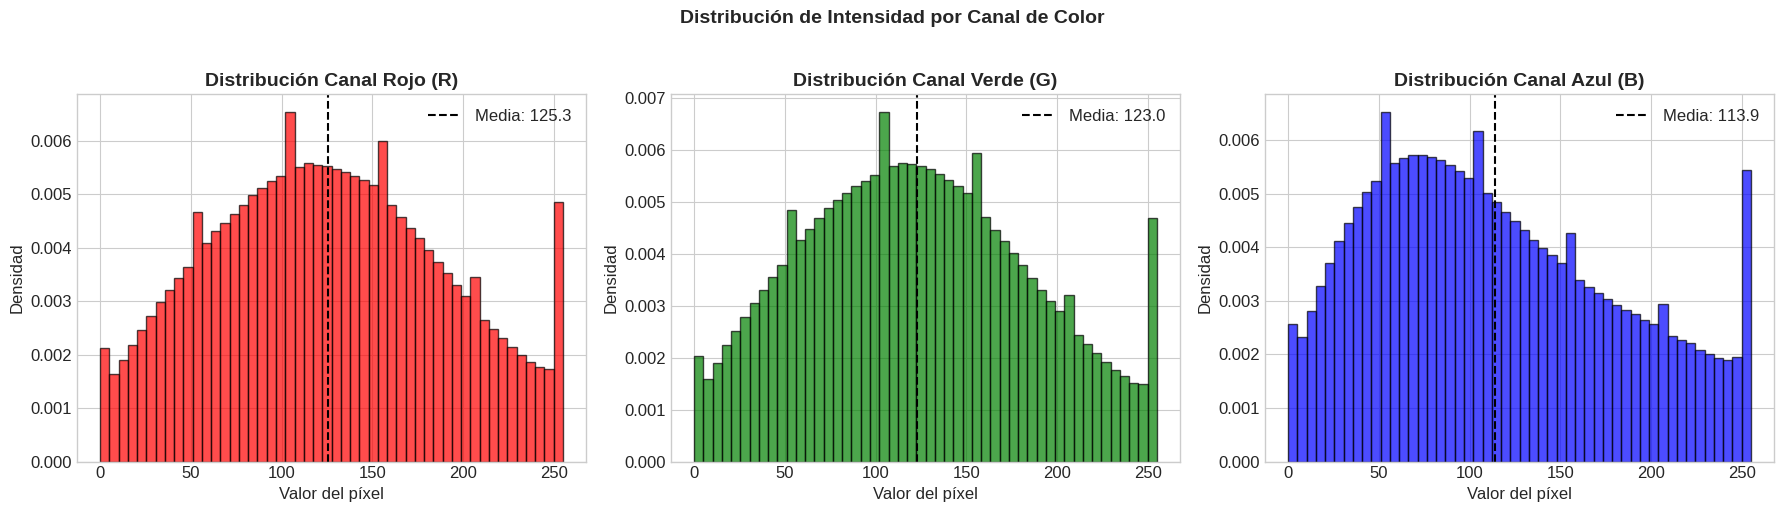

RGB promedio: R=125.3, G=123.0, B=113.9


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
channel_names = ['Rojo (R)', 'Verde (G)', 'Azul (B)']
channel_colors = ['red', 'green', 'blue']

for c in range(3):
    channel_data = x_train[:, :, :, c].flatten()
    axes[c].hist(channel_data, bins=50, color=channel_colors[c], alpha=0.7,
                 edgecolor='black', density=True)
    axes[c].set_title(f'Distribución Canal {channel_names[c]}', fontweight='bold')
    axes[c].set_xlabel('Valor del píxel')
    axes[c].set_ylabel('Densidad')
    axes[c].axvline(x=channel_data.mean(), color='black', linestyle='--',
                    label=f'Media: {channel_data.mean():.1f}')
    axes[c].legend()

plt.suptitle('Distribución de Intensidad por Canal de Color', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

mean_rgb = np.mean(x_train, axis=(0, 1, 2))
print(f"RGB promedio: R={mean_rgb[0]:.1f}, G={mean_rgb[1]:.1f}, B={mean_rgb[2]:.1f}")

## 4. Preprocesamiento

Normalizamos los píxeles al rango $[0, 1]$ dividiendo por 255. Definimos también el generador de **Data Augmentation** (rotaciones, desplazamientos horizontales/verticales y flip horizontal) que se usará a partir del Modelo 2.

> **Nota:** No aplicamos PCA ni reducción de dimensionalidad porque las CNNs se encargan de extraer features directamente de la estructura espacial 2D.

In [ ]:
# ============================================================
# 4. PREPROCESAMIENTO
# ============================================================

# Normalización [0, 1]
X_train = x_train.astype('float32') / 255.0
X_test = x_test.astype('float32') / 255.0
Y_train = y_train
Y_test = y_test

# Data Augmentation (se usará en modelos 2-5)
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test:  {X_test.shape}")
print(f"Rango normalizado: [{X_train.min():.1f}, {X_train.max():.1f}]")
print(f"Media global: {X_train.mean():.4f} | Std global: {X_train.std():.4f}")

Shape X_train: (50000, 32, 32, 3)
Shape X_test:  (10000, 32, 32, 3)
Rango normalizado: [0.0, 1.0]
Media global: 0.4734 | Std global: 0.2516


## 5. Funciones Auxiliares

Se definen funciones para evaluar modelos y graficar curvas de entrenamiento de forma estandarizada.

In [ ]:
# ============================================================
# 5. FUNCIONES AUXILIARES
# ============================================================

def evaluate_model(model, X_test, Y_test, model_name):
    """Evalúa un modelo en el conjunto de test y retorna métricas detalladas."""
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Métricas detalladas
    prec = precision_score(Y_test, y_pred, average='weighted')
    rec = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')

    print(f"\n{'='*60}")
    print(f"  {model_name}")
    print(f"{'='*60}")
    print(f"  Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"  Test Loss:      {test_loss:.4f}")
    print(f"  Precision:      {prec:.4f}")
    print(f"  Recall:         {rec:.4f}")
    print(f"  F1-Score:       {f1:.4f}")
    print(f"  Parámetros:     {model.count_params():,}")

    return {
        'model': model,
        'name': model_name,
        'test_acc': test_acc,
        'test_loss': test_loss,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'params': model.count_params()
    }

def plot_history(history, title):
    """Grafica curvas de aprendizaje (Accuracy y Loss)."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2, linestyle='--')
    ax1.set_title(f'{title} — Accuracy', fontweight='bold')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2, linestyle='--')
    ax2.set_title(f'{title} — Loss', fontweight='bold')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Almacenar resultados de todos los modelos
all_results = []
all_histories = {}

## 6. Modelo 1 — CNN Básica

Arquitectura base con 3 bloques convolucionales simples: `Conv → BatchNorm → MaxPool → Dropout(0.25)`, seguidos de una capa densa de 128 neuronas. **Sin data augmentation**, 30 epochs.

```
Input (32×32×3)
→ Conv2D(32, 3×3) → BN → MaxPool(2×2) → Dropout(0.25)
→ Conv2D(64, 3×3) → BN → MaxPool(2×2) → Dropout(0.25)
→ Conv2D(128, 3×3) → BN → MaxPool(2×2) → Dropout(0.25)
→ Flatten → Dense(128) → Dropout(0.5) → Dense(10, Softmax)
```

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)


Entrenando Modelo 1...
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.2743 - loss: 2.0603 - val_accuracy: 0.4611 - val_loss: 1.5309
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4599 - loss: 1.4854 - val_accuracy: 0.5891 - val_loss: 1.1697
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5367 - loss: 1.2997 - val_accuracy: 0.5910 - val_loss: 1.1909
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5832 - loss: 1.1788 - val_accuracy: 0.6312 - val_loss: 1.0629
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6157 - loss: 1.0921 - val_accuracy: 0.6352 - val_loss: 1.0398
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6427 - loss: 1.0287 - val_accuracy: 0.6391 - val_loss: 1.0524
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6618 - loss: 0.9779 - val_accuracy: 0.6062 - val_loss: 1.2094
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6764 - loss:

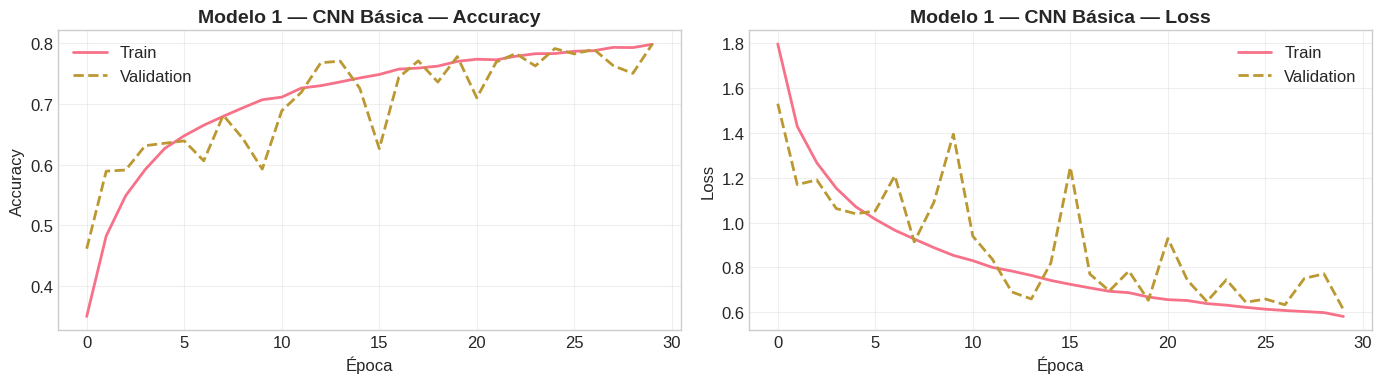


  Modelo 1: CNN Básica
  Test Accuracy:  0.7991 (79.91%)
  Test Loss:      0.6120
  Precision:      0.7987
  Recall:         0.7991
  F1-Score:       0.7968
  Parámetros:     357,706


In [ ]:
# ==========================================
# Modelo 1: CNN Básica (sin augmentation)
# ==========================================

model1 = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model1.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

print("\nEntrenando Modelo 1...")
history1 = model1.fit(X_train, Y_train, epochs=30, batch_size=64,
                      validation_data=(X_test, Y_test), verbose=1)

plot_history(history1, 'Modelo 1 — CNN Básica')
result1 = evaluate_model(model1, X_test, Y_test, 'Modelo 1: CNN Básica')
all_results.append(result1)
all_histories['M1: CNN Básica'] = history1

## 7. Modelo 2 — CNN + Data Augmentation

Misma arquitectura que el Modelo 1, pero con **data augmentation** (rotaciones, desplazamientos horizontales/verticales y flip horizontal) para mejorar la generalización. 30 epochs.

**Hipótesis:** La augmentación de datos expondrá al modelo a más variaciones de las imágenes, reduciendo el sobreajuste y mejorando la precisión en el conjunto de test.

In [ ]:
# ==========================================
# Modelo 2: CNN + Data Augmentation
# ==========================================

model2 = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model2.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

print("\nEntrenando Modelo 2...")
history2 = model2.fit(datagen.flow(X_train, Y_train, batch_size=64),
                      epochs=30, validation_data=(X_test, Y_test), verbose=1)

plot_history(history2, 'Modelo 2 — CNN + Data Augmentation')
result2 = evaluate_model(model2, X_test, Y_test, 'Modelo 2: CNN + Augmentation')
all_results.append(result2)
all_histories['M2: CNN + Aug'] = history2

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)


Entrenando Modelo 2...
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.2476 - loss: 2.1613 - val_accuracy: 0.4794 - val_loss: 1.4265
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.3927 - loss: 1.6380 - val_accuracy: 0.4438 - val_loss: 1.6224
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.4562 - loss: 1.4976 - val_accuracy: 0.5515 - val_loss: 1.2760
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.4902 - loss: 1.4070 - val_accuracy: 0.5939 - val_loss: 1.1559
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.5311 - loss: 1.3196 - val_accuracy: 0.6044 - val_loss: 1.1342
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.5520 - loss: 1.2632 - val_accuracy: 0.5405 - val_loss: 1.3664
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.5708 - loss: 1.2148 - val_accuracy: 0.5799 - val_loss: 1.2541
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 

## 8. Modelo 3 — CNN Doble Conv + Data Augmentation

Se **duplican las capas convolucionales** en cada bloque: `Conv → BN → Conv → BN → MaxPool → Dropout`. Esto permite a la red aprender representaciones más complejas antes del pooling. 30 epochs con data augmentation.

```
Input (32×32×3)
→ Conv2D(32, 3×3) → BN → Conv2D(32, 3×3) → BN → MaxPool → Dropout(0.25)
→ Conv2D(64, 3×3) → BN → Conv2D(64, 3×3) → BN → MaxPool → Dropout(0.25)
→ Conv2D(128, 3×3) → BN → Conv2D(128, 3×3) → BN → MaxPool → Dropout(0.25)
→ Flatten → Dense(128) → Dropout(0.5) → Dense(10, Softmax)
```

**Hipótesis:** Al tener dos convoluciones consecutivas antes del pooling, la red puede extraer patrones de mayor complejidad, similar a las arquitecturas VGGNet.

In [ ]:
# ==========================================
# Modelo 3: CNN Doble Conv + Augmentation
# ==========================================

model3 = Sequential([
    # Bloque 1
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Bloque 2
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Bloque 3
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Clasificador
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model3.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.summary()

print("\nEntrenando Modelo 3...")
history3 = model3.fit(datagen.flow(X_train, Y_train, batch_size=64),
                      epochs=30, validation_data=(X_test, Y_test), verbose=1)

plot_history(history3, 'Modelo 3 — Doble Conv + Augmentation')
result3 = evaluate_model(model3, X_test, Y_test, 'Modelo 3: Doble Conv + Aug')
all_results.append(result3)
all_histories['M3: Doble Conv'] = history3

## 9. Modelo 4 — CNN Doble Conv + LR Scheduler

Misma arquitectura que el Modelo 3, pero con **ReduceLROnPlateau** que reduce el learning rate cuando la validation loss deja de mejorar. 30 epochs con scheduling adaptativo.

**ReduceLROnPlateau** monitorea `val_loss` y reduce el LR por un factor de 0.2 si no hay mejora en 4 epochs consecutivos:

$$
\text{lr}_{\text{nuevo}} = \text{lr}_{\text{actual}} \times 0.2 \quad \text{si } \Delta\text{val\_loss} < 0 \text{ durante 4 epochs}
$$

In [ ]:
# ==========================================
# Modelo 4: CNN Doble Conv + LR Scheduler
# ==========================================

model4 = Sequential([
    # Bloque 1
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Bloque 2
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Bloque 3
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Clasificador
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model4.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model4.summary()

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4,
                                  min_lr=1e-6, verbose=1)

print("\nEntrenando Modelo 4...")
history4 = model4.fit(datagen.flow(X_train, Y_train, batch_size=64),
                      epochs=30, validation_data=(X_test, Y_test),
                      callbacks=[lr_scheduler], verbose=1)

plot_history(history4, 'Modelo 4 — Doble Conv + LR Scheduler')
result4 = evaluate_model(model4, X_test, Y_test, 'Modelo 4: Doble Conv + LR')
all_results.append(result4)
all_histories['M4: + LR Sched'] = history4

## 10. Modelo 5 — DenseNet-BC

Implementación de la arquitectura **DenseNet-BC** (Bottleneck + Compression). A diferencia de las CNNs secuenciales, DenseNet conecta **cada capa con todas las anteriores** mediante concatenación, lo que mejora el flujo de gradientes y la reutilización de features.

**Componentes:**
- **Dense Block**: Bloques donde cada capa recibe como input la concatenación de todos los feature maps anteriores
- **Bottleneck (B)**: Conv 1×1 antes del Conv 3×3 para reducir dimensionalidad
- **Compression (C)**: Transition layers que reducen canales con factor $\theta = 0.5$
- **Growth Rate** $k = 12$: Cada capa añade 12 feature maps nuevos

```
Input → Conv2D inicial (2k filtros)
→ DenseBlock(16 capas) → Transition (compression 0.5)
→ DenseBlock(16 capas) → Transition (compression 0.5)
→ DenseBlock(16 capas)
→ BN → ReLU → GlobalAveragePooling → Dense(10, Softmax)
```

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        648 │ input_layer[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         96 │ activation[0][0]  │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      1,152 │ activation_1[0][… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        192 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      5,184 │ activation_2[0][… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ activation[0][0], │
│ (Concatenate)       │ 36)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        144 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      1,728 │ activation_3[0][… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        192 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      5,184 │ activation_4[0][

 Total params: 793,246 (3.03 MB)

 Trainable params: 769,210 (2.93 MB)

 Non-trainable params: 24,036 (93.89 KB)


Entrenando Modelo 5 (DenseNet-BC)...
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 367s 316ms/step - accuracy: 0.4395 - loss: 1.5351 - val_accuracy: 0.4725 - val_loss: 1.8384 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 165s 210ms/step - accuracy: 0.6579 - loss: 0.9661 - val_accuracy: 0.6206 - val_loss: 1.1029 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 165s 211ms/step - accuracy: 0.7344 - loss: 0.7648 - val_accuracy: 0.6501 - val_loss: 1.1078 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 169s 216ms/step - accuracy: 0.7760 - loss: 0.6515 - val_accuracy: 0.7641 - val_loss: 0.7024 - learning_rate: 0.0010
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 169s 216ms/step - accuracy: 0.8042 - loss: 0.5671 - val_accuracy: 0.7309 - val_loss: 0.8287 - learning_rate: 0.0010
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 169s 216ms/step - accuracy: 0.8208 - loss: 0.5127 - val_accuracy: 0.6906 - val_loss: 1.0648 - learning_rate: 0.0010
Epoch 7/30
782/782 ━━━━━━━

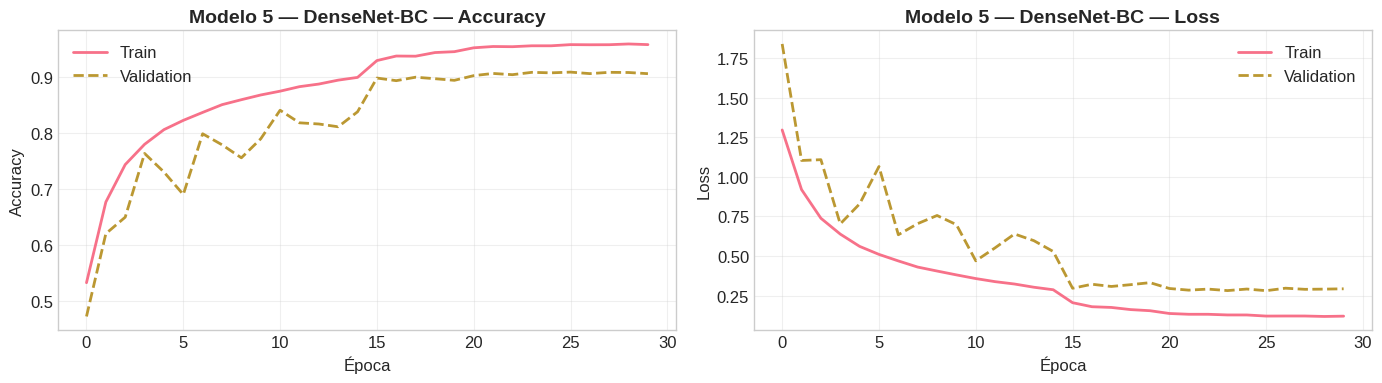


  Modelo 5: DenseNet-BC
  Test Accuracy:  0.9068 (90.68%)
  Test Loss:      0.2927
  Precision:      0.9078
  Recall:         0.9068
  F1-Score:       0.9061
  Parámetros:     793,246


In [ ]:
# ==========================================
# Modelo 5: DenseNet-BC
# ==========================================

def conv_block(x, growth_rate):
    """Bloque convolucional con bottleneck (Conv1x1 -> Conv3x3)."""
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(4 * growth_rate, (1, 1), padding='same', use_bias=False)(x1)

    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(x1)

    x = Concatenate(axis=-1)([x, x1])
    return x

def dense_block(x, num_layers, growth_rate):
    """Apila múltiples bloques convolucionales con conexiones densas."""
    for _ in range(num_layers):
        x = conv_block(x, growth_rate)
    return x

def transition_layer(x, compression_factor):
    """Reduce dimensiones espaciales y comprime canales."""
    num_filters = int(tf.keras.backend.int_shape(x)[-1] * compression_factor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (1, 1), padding='same', use_bias=False)(x)
    x = AveragePooling2D((2, 2), strides=2)(x)
    return x

# Hiperparámetros DenseNet
growth_rate = 12
compression_factor = 0.5
blocks = [16, 16, 16]

# Construcción del modelo
inputs = Input(shape=(32, 32, 3))
x = Conv2D(growth_rate * 2, (3, 3), padding='same', use_bias=False)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

for i in range(len(blocks)):
    x = dense_block(x, blocks[i], growth_rate)
    if i != len(blocks) - 1:
        x = transition_layer(x, compression_factor)

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax')(x)

model5 = Model(inputs=inputs, outputs=outputs)
model5.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model5.summary()

lr_scheduler5 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4,
                                   min_lr=1e-6, verbose=1)

print("\nEntrenando Modelo 5 (DenseNet-BC)...")
history5 = model5.fit(datagen.flow(X_train, Y_train, batch_size=64),
                      epochs=30, validation_data=(X_test, Y_test),
                      callbacks=[lr_scheduler5], verbose=1)

plot_history(history5, 'Modelo 5 — DenseNet-BC')
result5 = evaluate_model(model5, X_test, Y_test, 'Modelo 5: DenseNet-BC')
all_results.append(result5)
all_histories['M5: DenseNet-BC'] = history5

## 11. Evaluación Completa de los Modelos

Evaluamos cada modelo en el conjunto de **test** utilizando múltiples métricas:

| Métrica | Descripción | Importancia |
|---------|-------------|-------------|
| **Accuracy** | Proporción de predicciones correctas | Métrica global, útil con clases balanceadas |
| **Precision** | TP / (TP + FP) | ¿Cuántos de los predichos como clase X realmente lo son? |
| **Recall** | TP / (TP + FN) | ¿Cuántos de los que son clase X fueron detectados? |
| **F1-Score** | Media armónica de Precision y Recall | Equilibra ambas métricas |
| **Confusion Matrix** | Tabla de TP, TN, FP, FN por clase | Visualiza patrones de error detallados |

### 11.1 Tabla Comparativa de Métricas

In [29]:
# ============================================================
# 11.1 TABLA COMPARATIVA — RESUMEN DE MÉTRICAS
# ============================================================

print(f"{'='*90}")
print(f"{'RESUMEN COMPARATIVO — TEST SET':^90}")
print(f"{'='*90}")

# Tabla con pandas
df_results = pd.DataFrame({
    r['name']: {
        'Accuracy': f"{r['test_acc']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1-Score': f"{r['f1_score']:.4f}",
        'Loss': f"{r['test_loss']:.4f}",
        'Parameters': f"{r['params']:,}"
    }
    for r in all_results
}).T

print(df_results.to_string())

# Identificar mejor modelo
best = max(all_results, key=lambda x: x['test_acc'])
print(f"\nMejor modelo: {best['name']} con {best['test_acc']*100:.2f}% accuracy")

                              RESUMEN COMPARATIVO — TEST SET                              
                             Accuracy Precision  Recall F1-Score    Loss Parameters
Modelo 1: CNN Básica           0.7991    0.7987  0.7991   0.7968  0.6120    357,706
Modelo 2: CNN + Augmentation   0.7790    0.7832  0.7790   0.7741  0.6507    357,706
Modelo 3: Doble Conv + Aug     0.8334    0.8406  0.8334   0.8315  0.5130    552,362
Modelo 4: Doble Conv + LR      0.8548    0.8566  0.8548   0.8528  0.4452    552,362
Modelo 5: DenseNet-BC          0.9133    0.9137  0.9133   0.9128  0.2776    793,246

Mejor modelo: Modelo 5: DenseNet-BC con 91.33% accuracy


### 11.2 Classification Report Detallado por Clase

El `classification_report` de scikit-learn muestra Precision, Recall y F1-Score desglosados por cada una de las 10 clases, permitiendo identificar en qué clases cada modelo tiene mayor dificultad.

In [30]:
# ============================================================
# 11.2 CLASSIFICATION REPORT DETALLADO POR CLASE
# ============================================================

for r in all_results:
    print(f"\n{'='*70}")
    print(f"Classification Report — {r['name']}")
    print(f"{'='*70}")
    print(classification_report(Y_test, r['y_pred'], target_names=class_names, digits=4))


Classification Report — Modelo 1: CNN Básica
              precision    recall  f1-score   support

    airplane     0.7940    0.8170    0.8053      1000
  automobile     0.9432    0.8630    0.9013      1000
        bird     0.7333    0.6790    0.7051      1000
         cat     0.7121    0.5540    0.6232      1000
        deer     0.7186    0.8350    0.7724      1000
         dog     0.7331    0.7170    0.7250      1000
        frog     0.8186    0.8710    0.8440      1000
       horse     0.8343    0.8610    0.8474      1000
        ship     0.8159    0.9130    0.8617      1000
       truck     0.8837    0.8810    0.8823      1000

    accuracy                         0.7991     10000
   macro avg     0.7987    0.7991    0.7968     10000
weighted avg     0.7987    0.7991    0.7968     10000


Classification Report — Modelo 2: CNN + Augmentation
              precision    recall  f1-score   support

    airplane     0.8355    0.7870    0.8105      1000
  automobile     0.9227    0.847

### 11.3 Matrices de Confusión

Las matrices de confusión normalizadas por fila (recall por clase) permiten visualizar los patrones de error de cada modelo: qué clases se confunden entre sí.

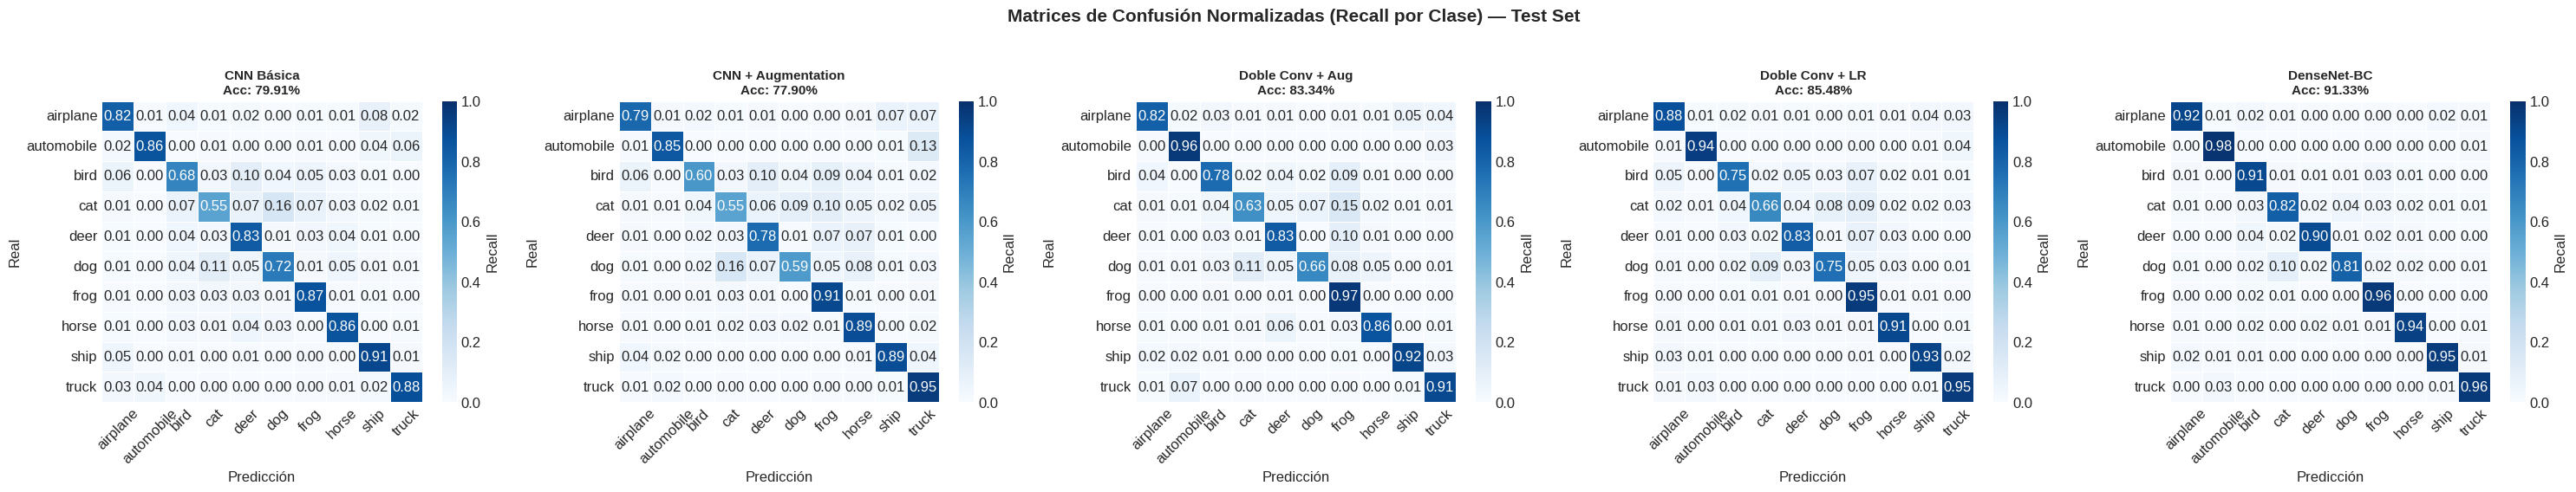


Análisis de clases más confundidas:
  Modelo 1: CNN Básica: 'cat' más confundida con 'dog' (161 veces)
  Modelo 2: CNN + Augmentation: 'dog' más confundida con 'cat' (157 veces)
  Modelo 3: Doble Conv + Aug: 'cat' más confundida con 'frog' (146 veces)
  Modelo 4: Doble Conv + LR: 'cat' más confundida con 'frog' (94 veces)
  Modelo 5: DenseNet-BC: 'dog' más confundida con 'cat' (97 veces)


In [31]:
# ============================================================
# 11.3 MATRICES DE CONFUSIÓN — SEABORN HEATMAPS
# ============================================================

n_models = len(all_results)
fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5.5))

for idx, r in enumerate(all_results):
    cm = confusion_matrix(Y_test, r['y_pred'])
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax = axes[idx] if n_models > 1 else axes
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, linewidths=0.5, linecolor='white',
                vmin=0, vmax=1, cbar_kws={'label': 'Recall'})
    ax.set_title(f"{r['name'].split(': ')[1]}\nAcc: {r['test_acc']:.2%}",
                 fontweight='bold', fontsize=11)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.suptitle('Matrices de Confusión Normalizadas (Recall por Clase) — Test Set',
             fontweight='bold', fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

# Análisis de clases más confundidas
print("\nAnálisis de clases más confundidas:")
for r in all_results:
    cm = confusion_matrix(Y_test, r['y_pred'])
    np.fill_diagonal(cm, 0)
    most_confused = np.unravel_index(cm.argmax(), cm.shape)
    print(f"  {r['name']}: '{class_names[most_confused[0]]}' más confundida con "
          f"'{class_names[most_confused[1]]}' ({cm[most_confused]} veces)")

## 12. Análisis Comparativo: Parámetros vs. Performance

### Curvas de Entrenamiento
Las curvas de Loss y Accuracy por época permiten diagnosticar:
- **Sobreajuste (Overfitting):** Gap creciente entre curvas de train y validation
- **Subajuste (Underfitting):** Ambas curvas estancadas en valores pobres
- **Buen ajuste:** Curvas convergentes con gap pequeño

### 12.1 Curvas de Entrenamiento Individuales

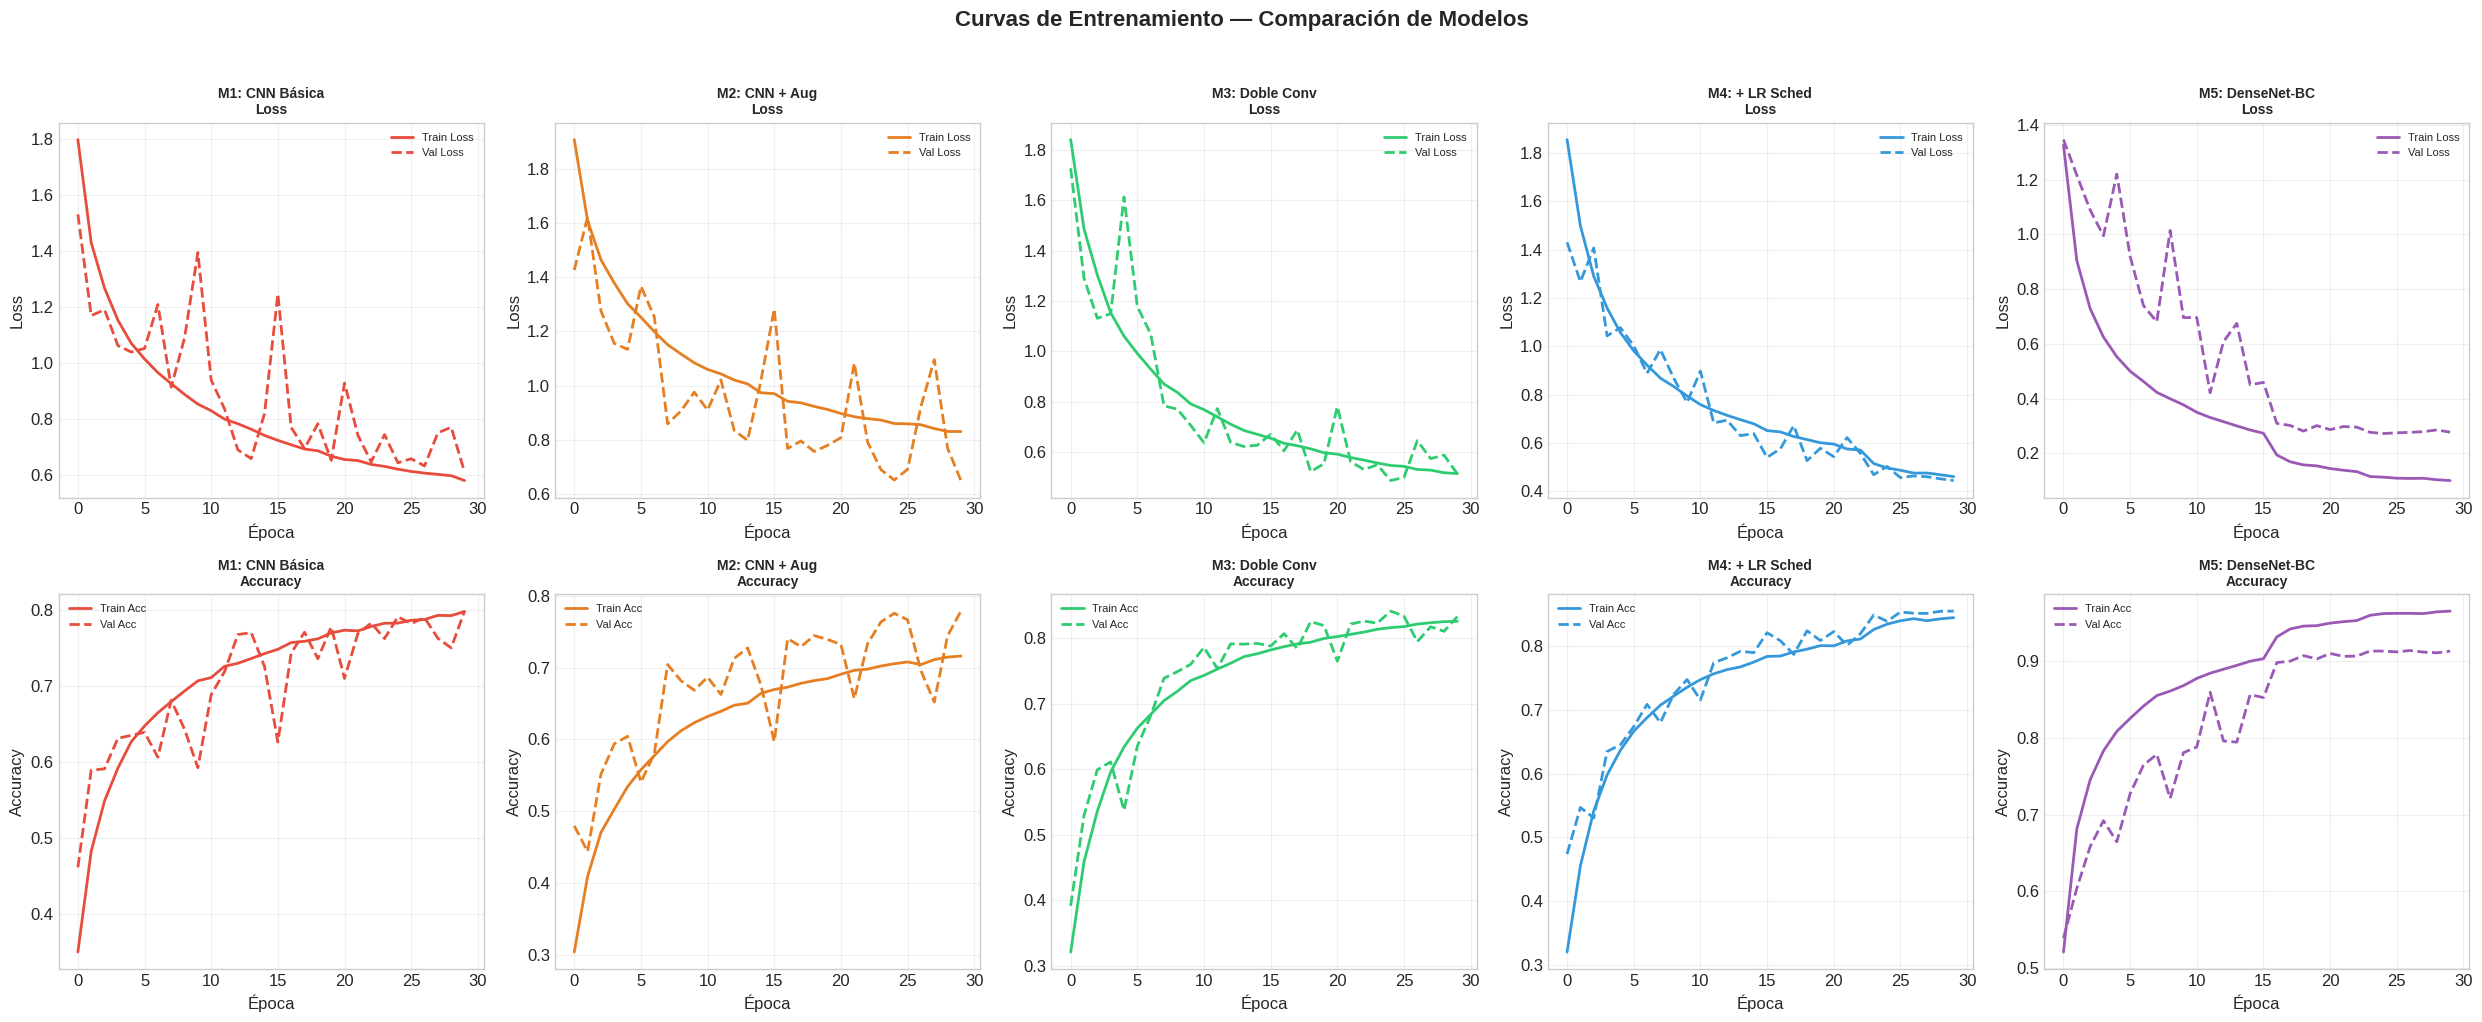

In [32]:
# ============================================================
# 12.1 CURVAS DE ENTRENAMIENTO — LOSS Y ACCURACY POR MODELO
# ============================================================

n_models = len(all_histories)
colors_models = ['#e74c3c', '#e67e22', '#2ecc71', '#3498db', '#9b59b6']

fig, axes = plt.subplots(2, n_models, figsize=(5 * n_models, 10))

for idx, (name, history) in enumerate(all_histories.items()):
    color = colors_models[idx]

    # === Loss ===
    axes[0][idx].plot(history.history['loss'], label='Train Loss',
                      color=color, linewidth=2)
    axes[0][idx].plot(history.history['val_loss'], label='Val Loss',
                      color=color, linewidth=2, linestyle='--')
    axes[0][idx].set_title(f'{name}\nLoss', fontweight='bold', fontsize=10)
    axes[0][idx].set_xlabel('Época')
    axes[0][idx].set_ylabel('Loss')
    axes[0][idx].legend(fontsize=8)
    axes[0][idx].grid(True, alpha=0.3)

    # === Accuracy ===
    axes[1][idx].plot(history.history['accuracy'], label='Train Acc',
                      color=color, linewidth=2)
    axes[1][idx].plot(history.history['val_accuracy'], label='Val Acc',
                      color=color, linewidth=2, linestyle='--')
    axes[1][idx].set_title(f'{name}\nAccuracy', fontweight='bold', fontsize=10)
    axes[1][idx].set_xlabel('Época')
    axes[1][idx].set_ylabel('Accuracy')
    axes[1][idx].legend(fontsize=8)
    axes[1][idx].grid(True, alpha=0.3)

plt.suptitle('Curvas de Entrenamiento — Comparación de Modelos',
             fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### 12.2 Curvas Comparativas Superpuestas

Superponemos las curvas de validación de todos los modelos para observar la evolución relativa del rendimiento.

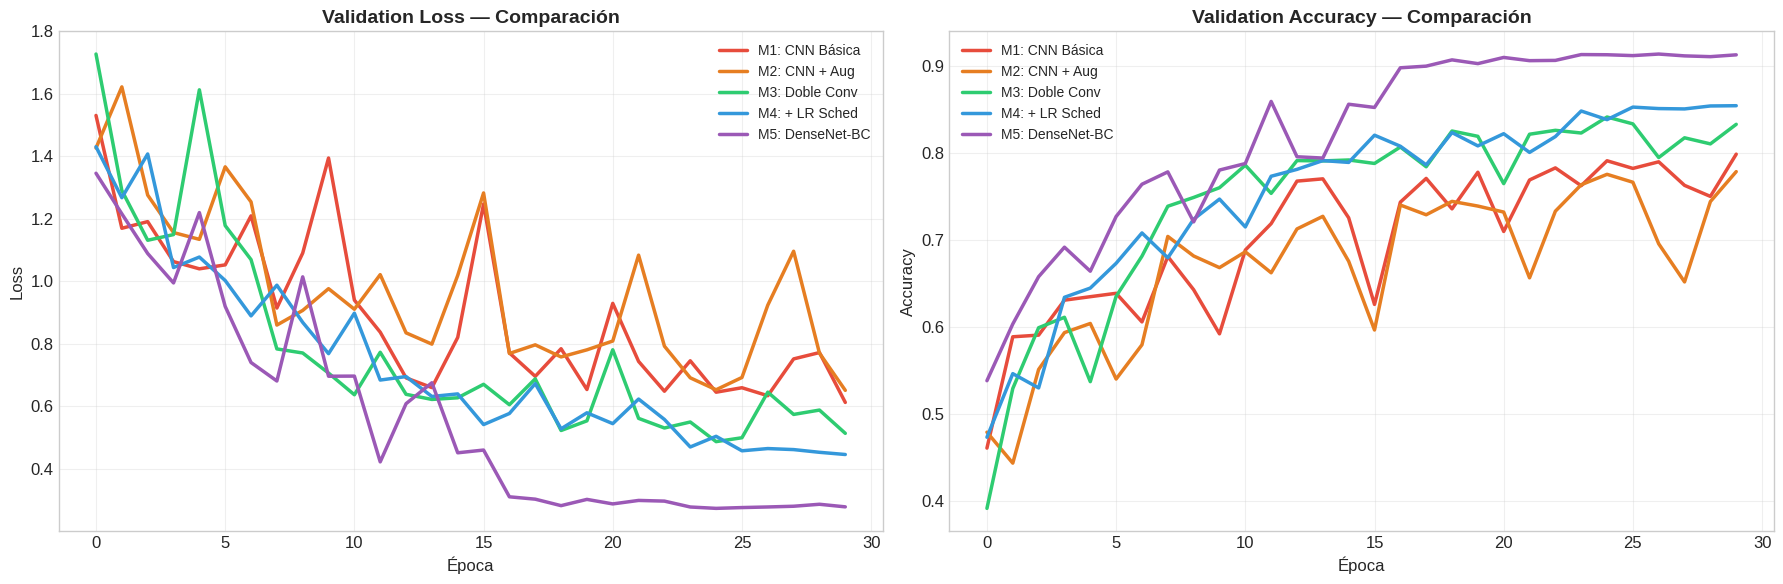

In [33]:
# ============================================================
# 12.2 CURVAS COMPARATIVAS SUPERPUESTAS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
colors_hist = ['#e74c3c', '#e67e22', '#2ecc71', '#3498db', '#9b59b6']

for idx, (name, history) in enumerate(all_histories.items()):
    color = colors_hist[idx]
    axes[0].plot(history.history['val_loss'], label=name, color=color, linewidth=2.5)
    axes[1].plot(history.history['val_accuracy'], label=name, color=color, linewidth=2.5)

axes[0].set_title('Validation Loss — Comparación', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Validation Accuracy — Comparación', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 12.3 Gráfico de Barras — Métricas por Modelo

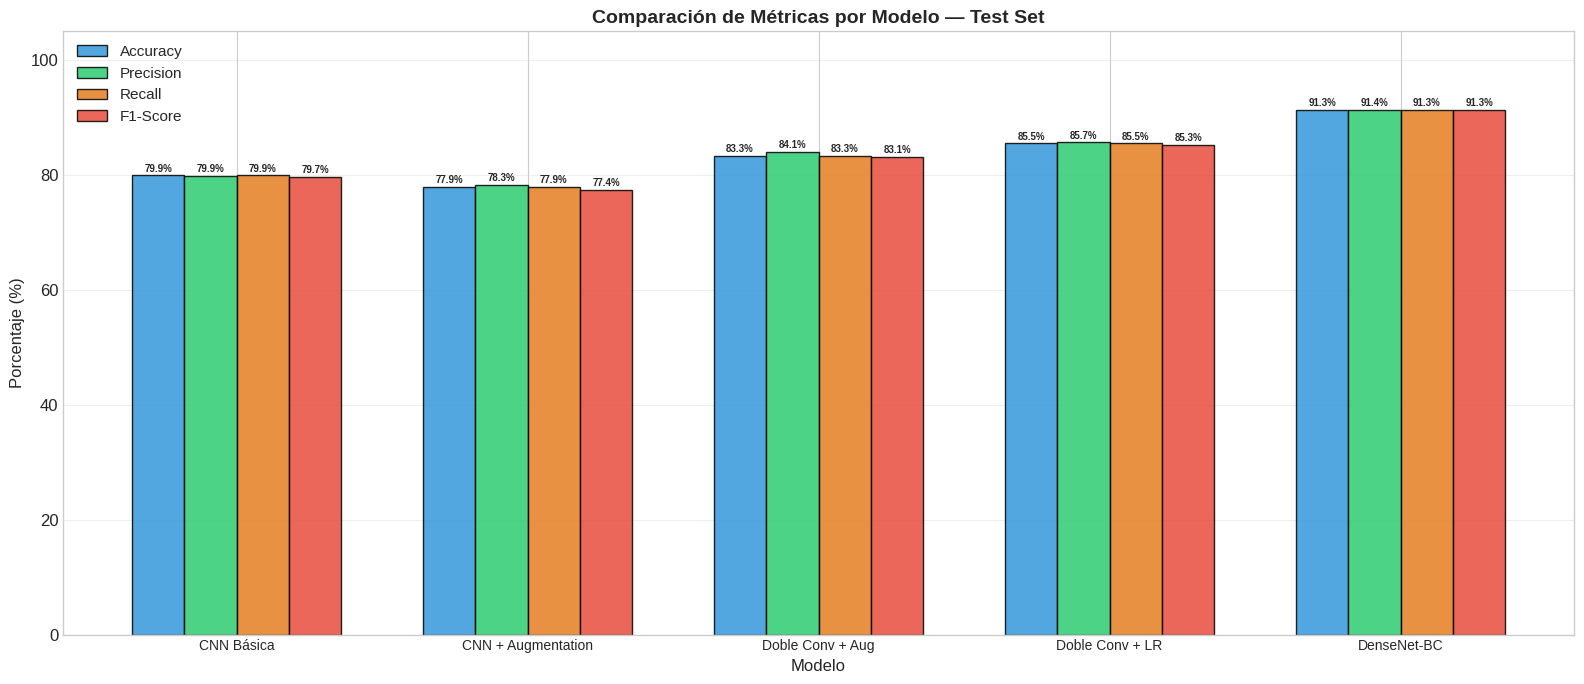

In [34]:
# ============================================================
# 12.3 GRÁFICO DE BARRAS COMPARATIVO — MÉTRICAS POR MODELO
# ============================================================

fig, ax = plt.subplots(figsize=(16, 7))

model_names_short = [r['name'].split(': ')[1] for r in all_results]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(model_names_short))
width = 0.18
metric_colors = ['#3498db', '#2ecc71', '#e67e22', '#e74c3c']

for i, metric in enumerate(metrics_names):
    key_map = {'Accuracy': 'test_acc', 'Precision': 'precision',
               'Recall': 'recall', 'F1-Score': 'f1_score'}
    values = [r[key_map[metric]] * 100 for r in all_results]
    bars = ax.bar(x + i * width, values, width, label=metric,
                  color=metric_colors[i], alpha=0.85, edgecolor='black')
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=7, fontweight='bold')

ax.set_title('Comparación de Métricas por Modelo — Test Set', fontweight='bold', fontsize=14)
ax.set_xlabel('Modelo')
ax.set_ylabel('Porcentaje (%)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(model_names_short, fontsize=10)
ax.legend(fontsize=11)
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 12.4 Parámetros vs. Performance

¿Más parámetros implican mejor rendimiento? Analizamos la eficiencia de cada modelo.

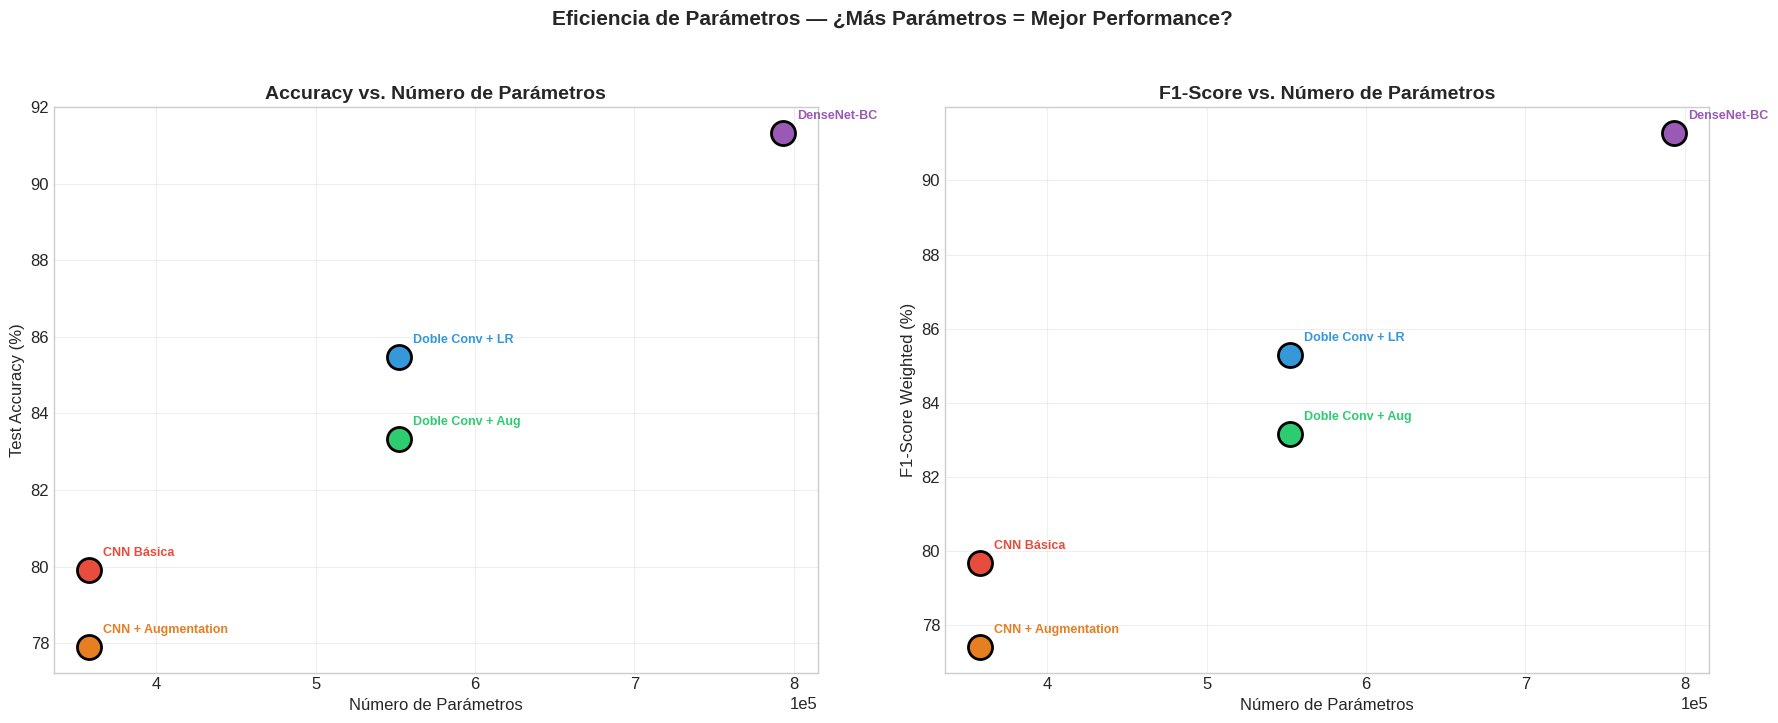


EFICIENCIA DE PARÁMETROS:
Modelo                               Params   Accuracy    Acc/100K params
Modelo 1: CNN Básica                357,706     79.91%            22.34%
Modelo 2: CNN + Augmentation        357,706     77.90%            21.78%
Modelo 3: Doble Conv + Aug          552,362     83.34%            15.09%
Modelo 4: Doble Conv + LR           552,362     85.48%            15.48%
Modelo 5: DenseNet-BC               793,246     91.33%            11.51%

Mayor eficiencia = mejor accuracy con menos parámetros.


In [35]:
# ============================================================
# 12.4 PARÁMETROS VS. PERFORMANCE
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors_plot = ['#e74c3c', '#e67e22', '#2ecc71', '#3498db', '#9b59b6']

# Accuracy vs Parámetros
for i, r in enumerate(all_results):
    axes[0].scatter(r['params'], r['test_acc'] * 100, color=colors_plot[i],
                    s=300, zorder=5, edgecolors='black', linewidths=2)
    axes[0].annotate(r['name'].split(': ')[1], (r['params'], r['test_acc'] * 100),
                     textcoords="offset points", xytext=(10, 10),
                     fontsize=9, fontweight='bold', color=colors_plot[i])

axes[0].set_title('Accuracy vs. Número de Parámetros', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Número de Parámetros')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].grid(True, alpha=0.3)
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# F1-Score vs Parámetros
for i, r in enumerate(all_results):
    axes[1].scatter(r['params'], r['f1_score'] * 100, color=colors_plot[i],
                    s=300, zorder=5, edgecolors='black', linewidths=2)
    axes[1].annotate(r['name'].split(': ')[1], (r['params'], r['f1_score'] * 100),
                     textcoords="offset points", xytext=(10, 10),
                     fontsize=9, fontweight='bold', color=colors_plot[i])

axes[1].set_title('F1-Score vs. Número de Parámetros', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Número de Parámetros')
axes[1].set_ylabel('F1-Score Weighted (%)')
axes[1].grid(True, alpha=0.3)
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

plt.suptitle('Eficiencia de Parámetros — ¿Más Parámetros = Mejor Performance?',
             fontweight='bold', fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

# Tabla de eficiencia
print(f"\nEFICIENCIA DE PARÁMETROS:")
print(f"{'Modelo':<30} {'Params':>12} {'Accuracy':>10} {'Acc/100K params':>18}")
print("=" * 75)
for r in all_results:
    eff = (r['test_acc'] * 100) / (r['params'] / 100000)
    print(f"{r['name']:<30} {r['params']:>12,} {r['test_acc']:>10.2%} {eff:>16.2f}%")
print(f"\nMayor eficiencia = mejor accuracy con menos parámetros.")

### 12.5 F1-Score por Clase y Modelo

Desglosamos el F1-Score por cada una de las 10 clases para identificar en qué clases cada modelo destaca o tiene dificultades.

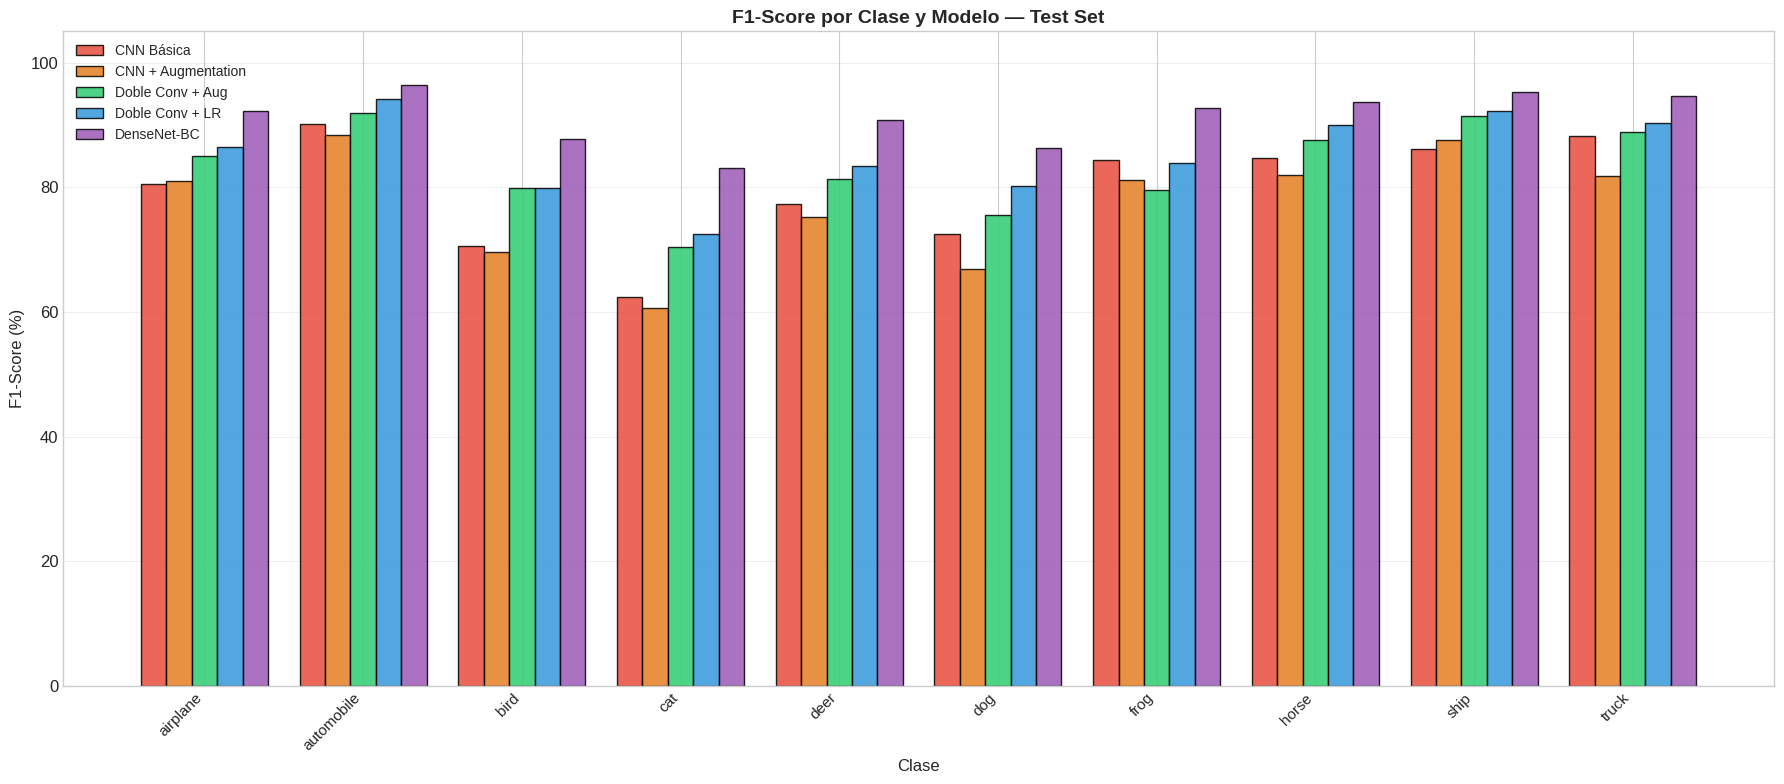


F1-SCORE POR CLASE (%) — Detalle
Clase               CNN BásicaCNN + AugmentationDoble Conv + AugDoble Conv + LR    DenseNet-BC
-----------------------------------------------------------------------------------------------
airplane                 80.5%          81.1%          85.0%          86.4%          92.3%
automobile               90.1%          88.3%          91.9%          94.2%          96.4%
bird                     70.5%          69.7%          79.9%          79.9%          87.7%
cat                      62.3%          60.6%          70.4%          72.4%          83.1%
deer                     77.2%          75.2%          81.4%          83.3%          90.7%
dog                      72.5%          66.9%          75.6%          80.2%          86.3%
frog                     84.4%          81.2%          79.6%          83.9%          92.7%
horse                    84.7%          82.0%          87.5%          89.9%          93.7%
ship                     86.2%          87.5%  

In [36]:
# ============================================================
# 12.5 F1-SCORE POR CLASE Y MODELO
# ============================================================

fig, ax = plt.subplots(figsize=(18, 8))

x = np.arange(len(class_names))
n_models = len(all_results)
width = 0.8 / n_models
colors_f1 = ['#e74c3c', '#e67e22', '#2ecc71', '#3498db', '#9b59b6']

for i, r in enumerate(all_results):
    f1_per_class = f1_score(Y_test, r['y_pred'], average=None)
    bars = ax.bar(x + i * width, f1_per_class * 100, width,
                  label=r['name'].split(': ')[1],
                  color=colors_f1[i], alpha=0.85, edgecolor='black')

ax.set_title('F1-Score por Clase y Modelo — Test Set', fontweight='bold', fontsize=14)
ax.set_xlabel('Clase', fontsize=12)
ax.set_ylabel('F1-Score (%)', fontsize=12)
ax.set_xticks(x + width * (n_models - 1) / 2)
ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=10)
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla detallada
print(f"\n{'='*95}")
print("F1-SCORE POR CLASE (%) — Detalle")
print(f"{'='*95}")
header = f"{'Clase':<15}"
for r in all_results:
    header += f"{r['name'].split(': ')[1]:>15}"
print(header)
print("-" * 95)
for c_idx, c_name in enumerate(class_names):
    row = f"{c_name:<15}"
    for r in all_results:
        f1_c = f1_score(Y_test, r['y_pred'], average=None)[c_idx]
        row += f"{f1_c*100:>14.1f}%"
    print(row)

## 13. Análisis Avanzado

### 13.1 Visualización de Kernels (Filtros) Aprendidos

Una de las ventajas de las CNNs es su **interpretabilidad parcial**: podemos visualizar los filtros de la primera capa convolucional para entender qué patrones de bajo nivel ha aprendido la red.

**Lo que típicamente aprende la primera capa:**
- Detectores de bordes (horizontales, verticales, diagonales)
- Detectores de color
- Detectores de texturas simples

Estos filtros actúan como los "bloques de construcción" sobre los cuales las capas posteriores construyen representaciones de mayor nivel (formas, partes de objetos, objetos completos).

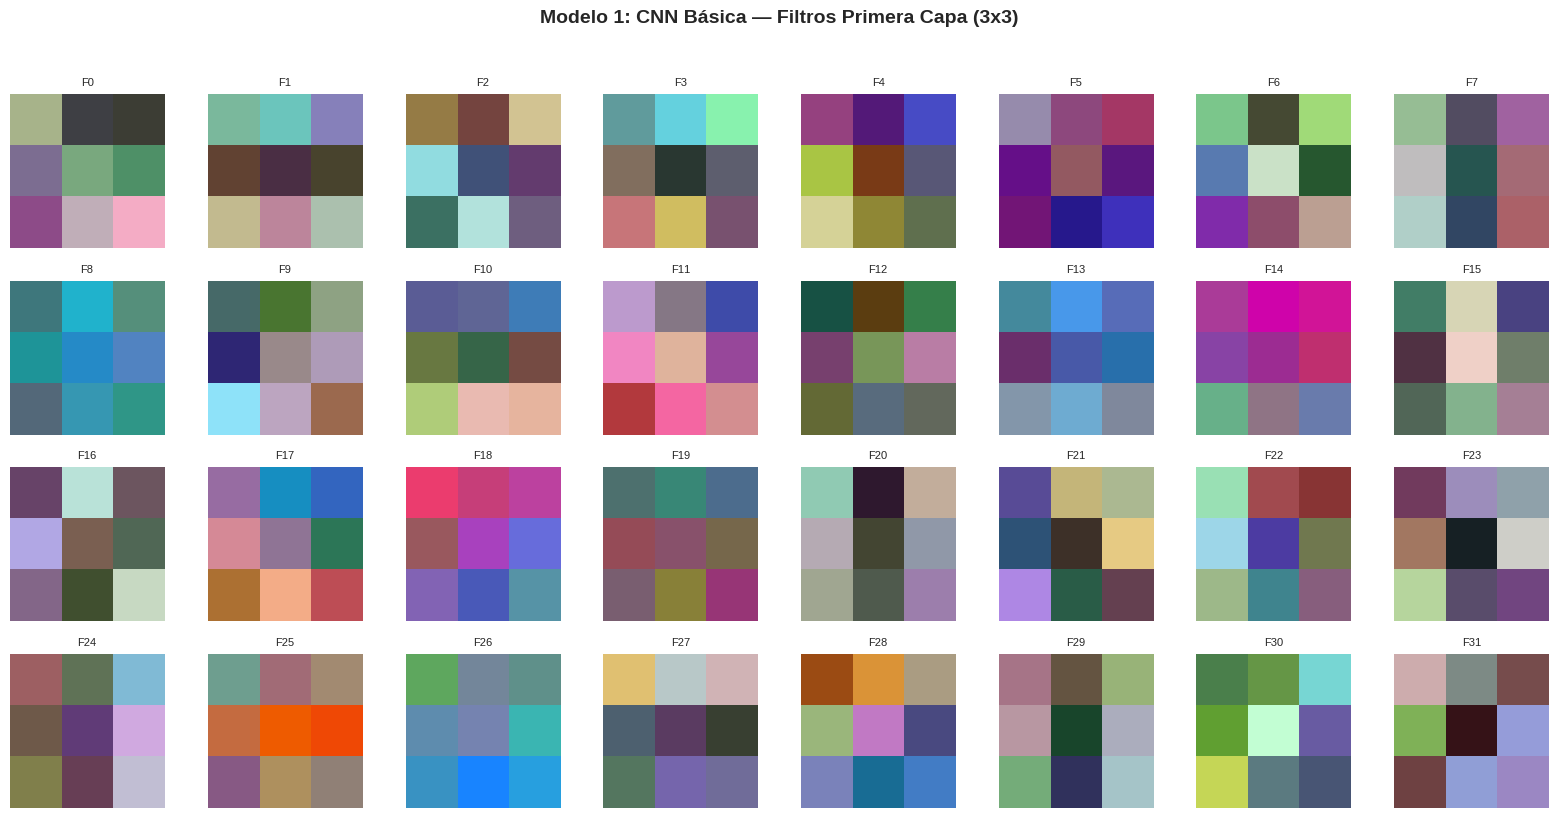

Modelo 1: CNN Básica: 32 filtros de 3x3x3



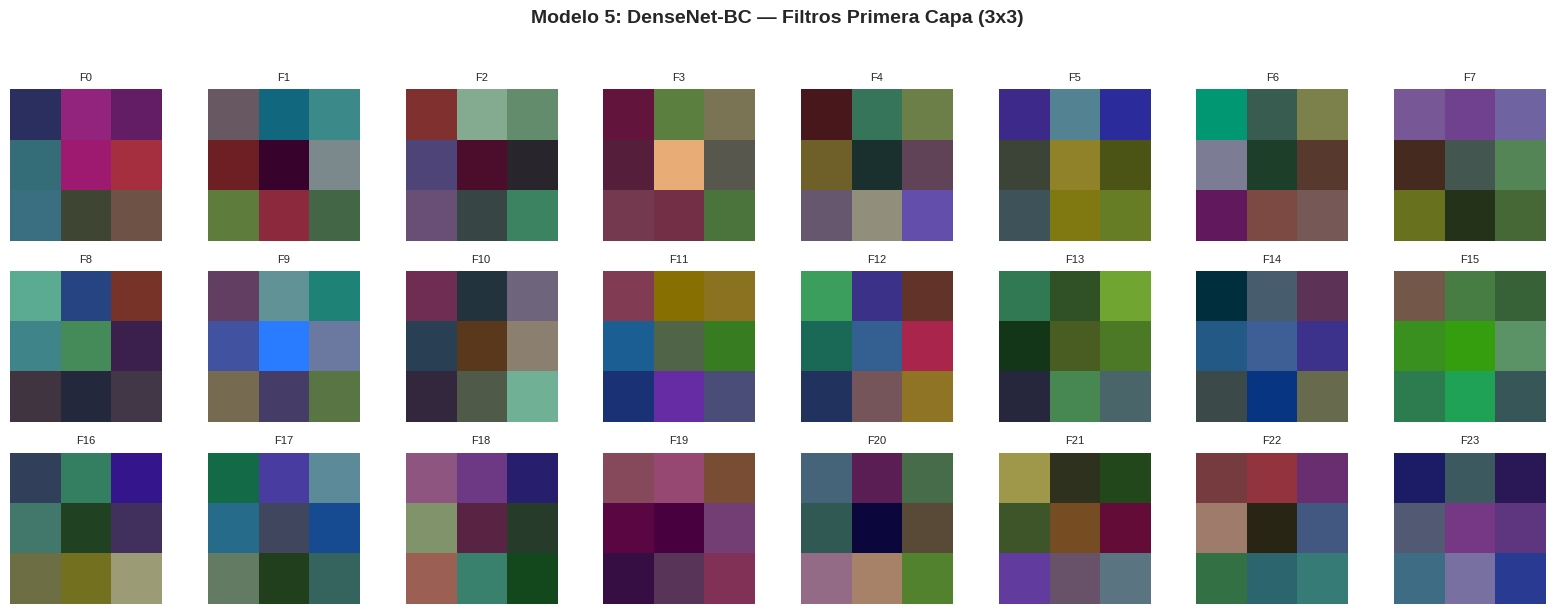

Modelo 5: DenseNet-BC: 24 filtros de 3x3x3


In [37]:
# ============================================================
# 13.1 VISUALIZACIÓN DE KERNELS — MODELOS 1 Y 5
# ============================================================

def visualize_kernels(model, model_name):
    """Visualiza los filtros de la primera capa convolucional."""
    conv_layer = None
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            conv_layer = layer
            break

    if conv_layer is None:
        print(f"No se encontró capa Conv2D en {model_name}")
        return

    weights = conv_layer.get_weights()[0]  # (kernel_h, kernel_w, channels, n_filters)
    n_filters = weights.shape[3]
    kernel_size = weights.shape[0]

    # Normalizar pesos para visualización [0, 1]
    w_min, w_max = weights.min(), weights.max()
    weights_norm = (weights - w_min) / (w_max - w_min + 1e-8)

    cols = 8
    rows = int(np.ceil(n_filters / cols))
    fig, axes_k = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes_flat = axes_k.flatten()

    for i in range(n_filters):
        if weights_norm.shape[2] == 3:
            kernel_img = weights_norm[:, :, :, i]
        else:
            kernel_img = weights_norm[:, :, 0, i]
        axes_flat[i].imshow(kernel_img, interpolation='nearest')
        axes_flat[i].set_title(f'F{i}', fontsize=8)
        axes_flat[i].axis('off')

    for i in range(n_filters, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.suptitle(f'{model_name} — Filtros Primera Capa ({kernel_size}x{kernel_size})',
                 fontweight='bold', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    print(f"{model_name}: {n_filters} filtros de {kernel_size}x{kernel_size}x{weights.shape[2]}")

# Visualizar filtros del Modelo 1 (CNN Básica) y Modelo 5 (DenseNet)
visualize_kernels(model1, 'Modelo 1: CNN Básica')
print()
visualize_kernels(model5, 'Modelo 5: DenseNet-BC')

### 13.2 Visualización de Feature Maps (Activaciones Intermedias)

Los feature maps muestran cómo la primera capa convolucional transforma una imagen de entrada, revelando los patrones espaciales que detectan los filtros aprendidos.

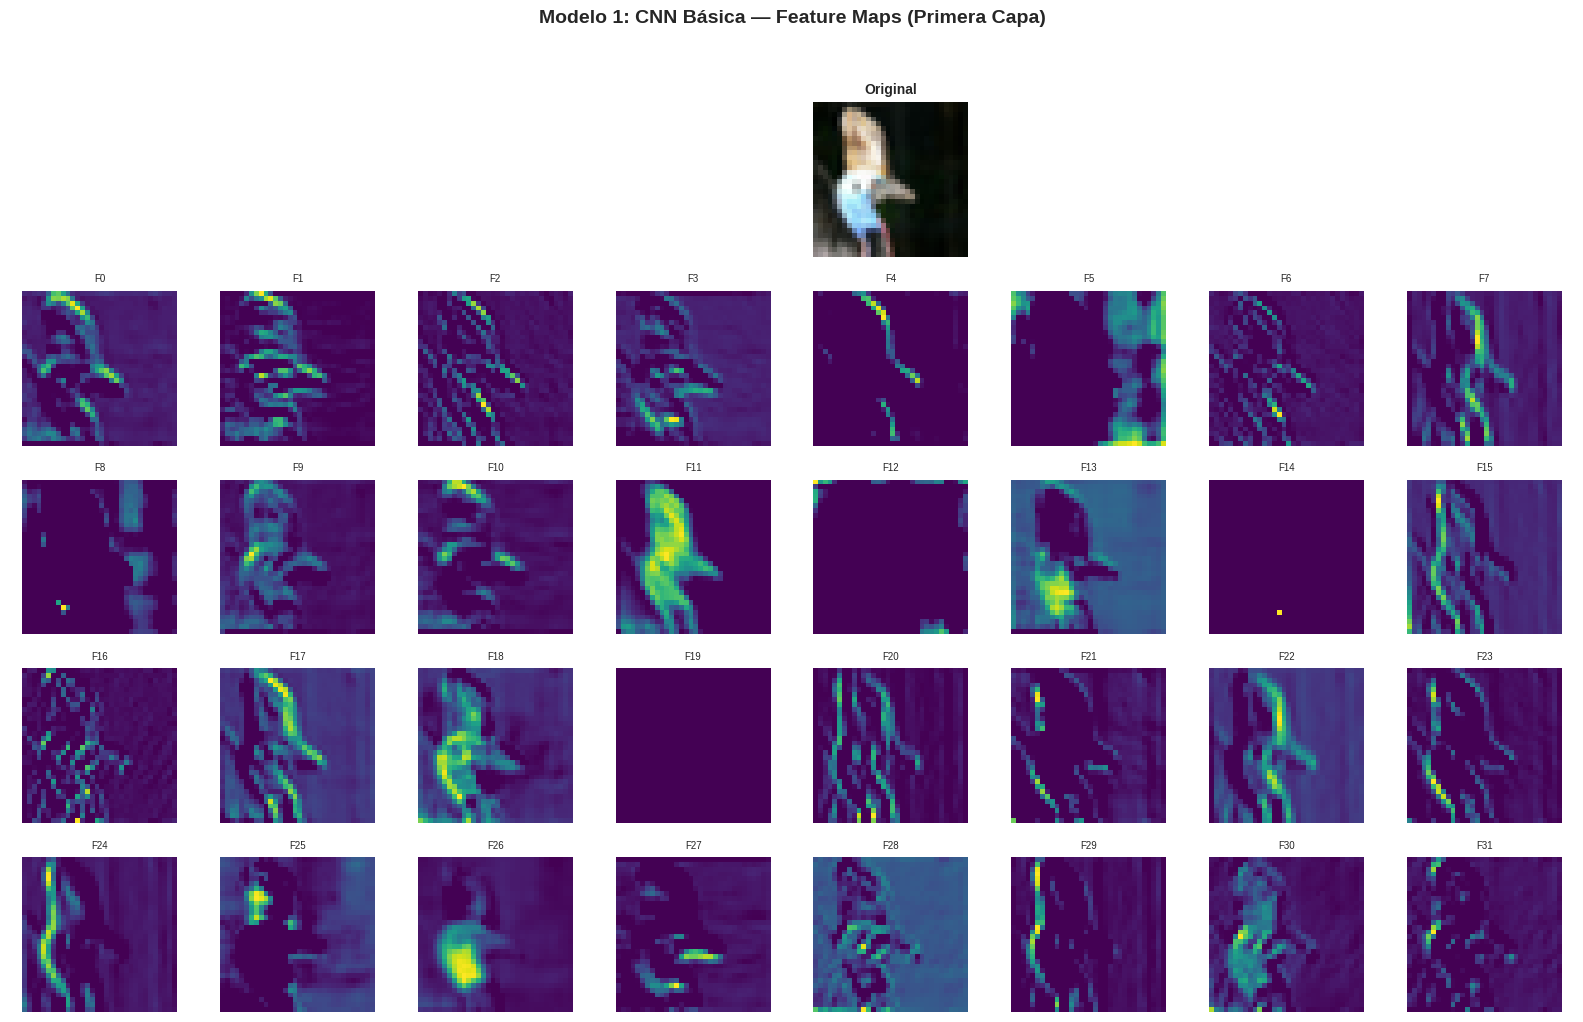

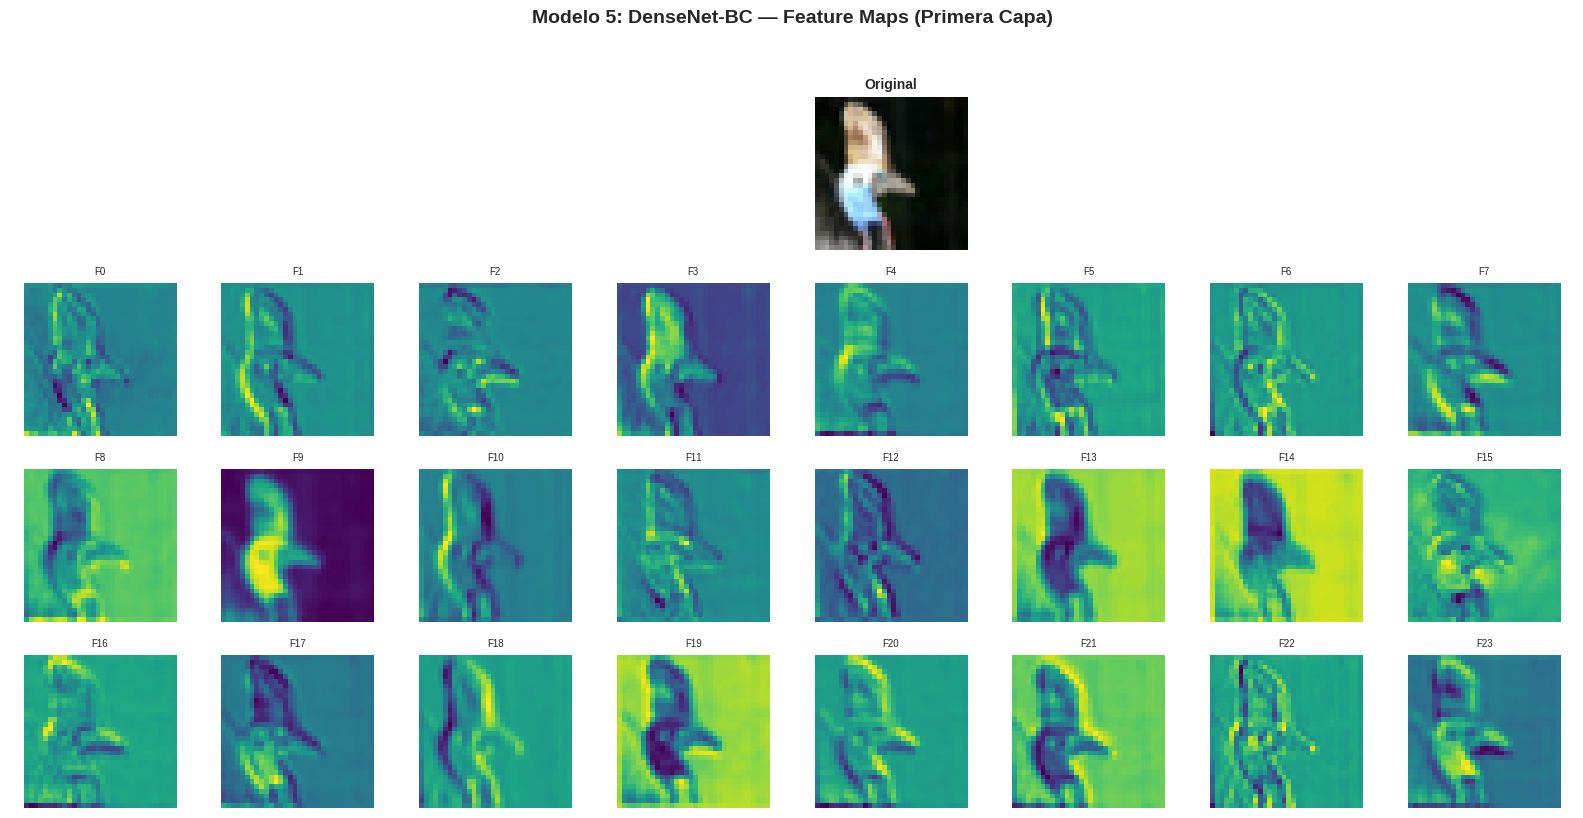

In [40]:
# ============================================================
# 13.2 FEATURE MAPS — ACTIVACIONES DE LA PRIMERA CAPA
# ============================================================

def visualize_feature_maps(model, model_name, image, n_columns=8):
    """Visualiza los mapas de características de la primera capa Conv2D."""
    # Buscador recursivo de la primera Conv2D (maneja capas anidadas / submodelos)
    def find_first_conv(layer_or_model):
        # Si el objeto es directamente una Conv2D
        if isinstance(layer_or_model, Conv2D):
            return layer_or_model
        # Si tiene atributo 'layers' recorremos recursivamente
        if hasattr(layer_or_model, 'layers') and layer_or_model.layers:
            for sub in layer_or_model.layers:
                found = find_first_conv(sub)
                if found is not None:
                    return found
        # También chequea submodules (útil en algunos modelos)
        if hasattr(layer_or_model, 'submodules'):
            for sub in layer_or_model.submodules:
                if sub is layer_or_model:
                    continue
                found = find_first_conv(sub)
                if found is not None:
                    return found
        return None

    first_conv = find_first_conv(model)
    if first_conv is None:
        print(f"No se encontraron capas Conv2D en {model_name}")
        return

    # Construir un modelo intermedio que vaya desde las entradas originales
    # hasta la salida de la primera Conv2D (esto evita llamar capas individualmente).
    try:
        intermediate_model = tf.keras.Model(inputs=model.inputs, outputs=first_conv.output)
    except Exception as e:
        # En modelos muy personalizados, puede fallar; informamos el error
        print(f"No se pudo construir modelo intermedio: {e}")
        return

    # Obtener activaciones (preparar la imagen como batch de 1)
    x_input = np.expand_dims(image, axis=0).astype('float32')
    activations = intermediate_model.predict(x_input, verbose=0)
    activations = activations[0]  # quitar dimensión batch

    n_filters = activations.shape[-1]
    rows = int(np.ceil(n_filters / n_columns))

    # Crear grid de plots (rows + 1 fila para la imagen original)
    fig, axes_fm = plt.subplots(rows + 1, n_columns, figsize=(n_columns * 2, (rows + 1) * 2))
    axes_fm = np.atleast_2d(axes_fm)  # asegurar que sea indexable con [fila][col]

    # Imagen original centrada
    for j in range(n_columns):
        axes_fm[0][j].axis('off')
    mid_col = n_columns // 2
    # Mostrar la imagen original (si tiene canales, asumir formato HxWxC)
    axes_fm[0][mid_col].imshow(image.astype(np.uint8) if image.dtype != np.float32 else image)
    axes_fm[0][mid_col].set_title('Original', fontweight='bold', fontsize=10)

    # Feature maps
    for i in range(n_filters):
        row = (i // n_columns) + 1
        col = i % n_columns
        # normalizar el mapa para mejor visualización
        fmap = activations[:, :, i]
        # evitar divisiones por cero
        vmin, vmax = fmap.min(), fmap.max()
        if vmax > vmin:
            axes_fm[row][col].imshow((fmap - vmin) / (vmax - vmin), cmap='viridis')
        else:
            axes_fm[row][col].imshow(fmap, cmap='viridis')
        axes_fm[row][col].set_title(f'F{i}', fontsize=7)
        axes_fm[row][col].axis('off')

    # Apagar ejes sobrantes si hay
    total_cells = rows * n_columns
    for idx in range(n_filters, total_cells):
        row = (idx // n_columns) + 1
        col = idx % n_columns
        axes_fm[row][col].axis('off')

    plt.suptitle(f'{model_name} — Feature Maps (Primera Capa)',
                 fontweight='bold', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Seleccionar imagen de ejemplo
sample_image = X_test[np.random.choice(len(X_test))]

visualize_feature_maps(model1, 'Modelo 1: CNN Básica', sample_image)
visualize_feature_maps(model5, 'Modelo 5: DenseNet-BC', sample_image)

### 13.3 Predicciones Visuales — Aciertos y Errores

Visualizamos predicciones correctas e incorrectas de cada modelo para entender cualitativamente dónde aciertan y fallan.

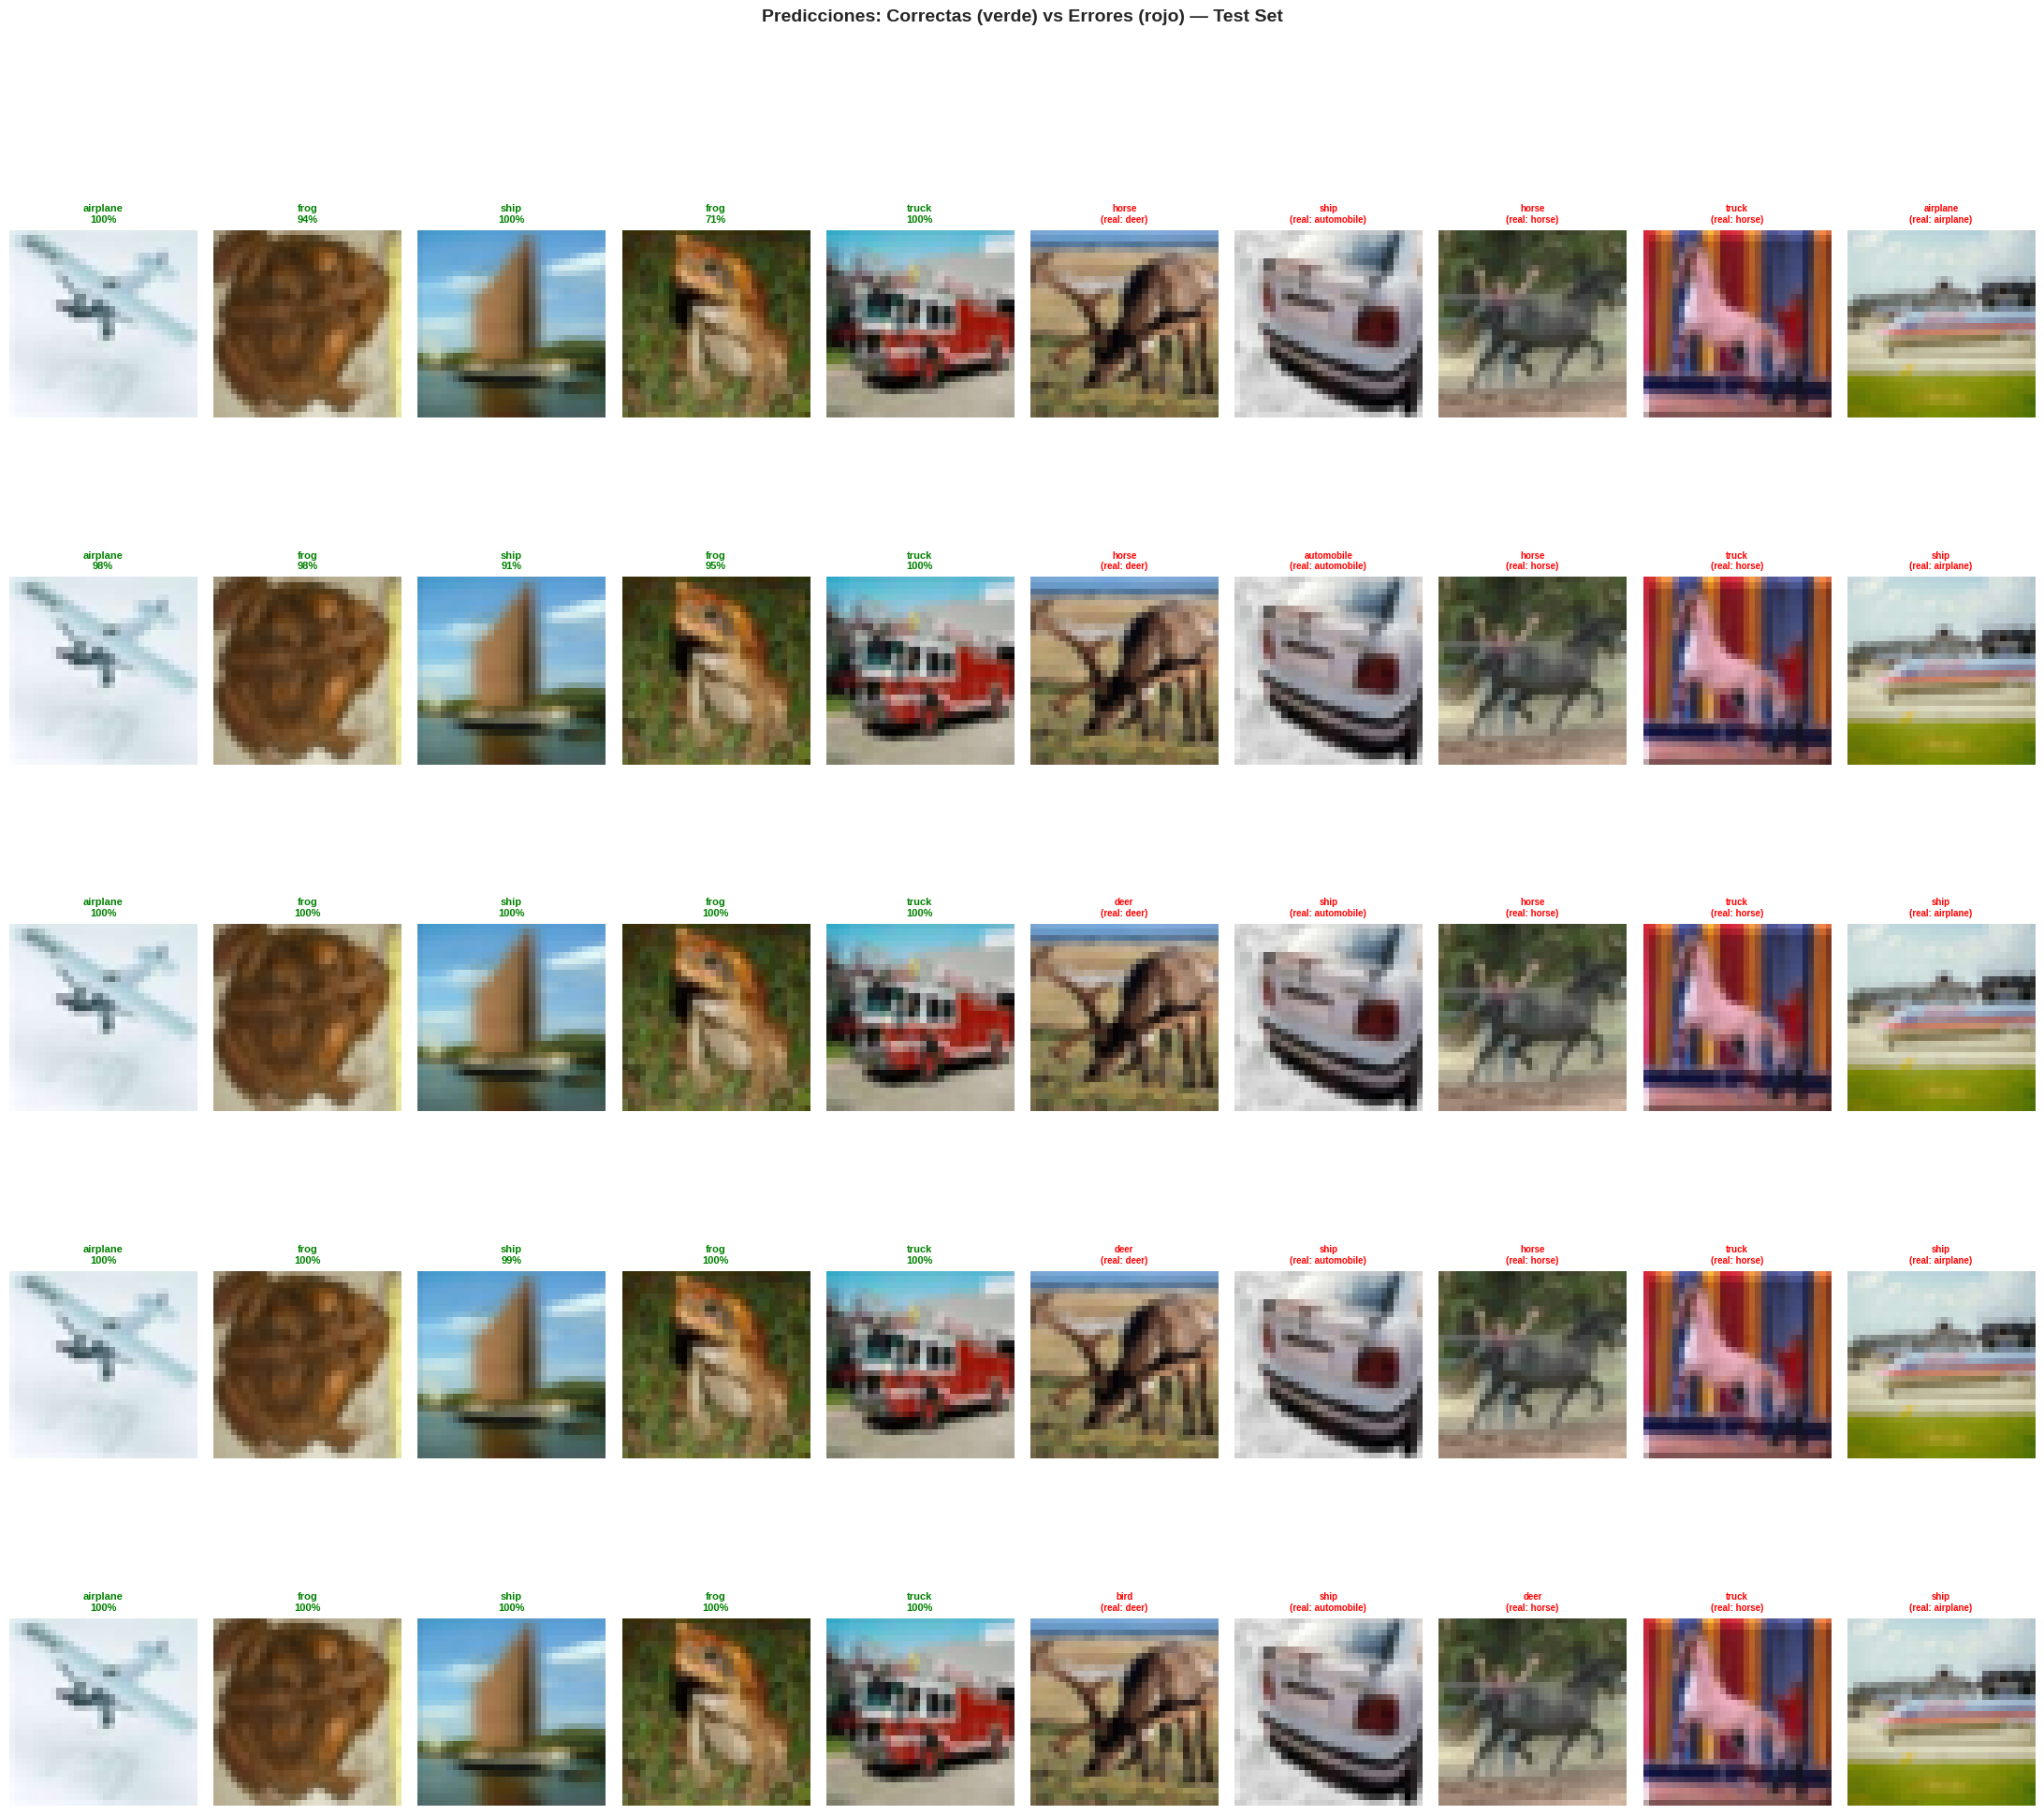

In [39]:
# ============================================================
# 13.3 PREDICCIONES VISUALES — ACIERTOS Y ERRORES
# ============================================================

n_models = len(all_results)
fig, axes = plt.subplots(n_models, 10, figsize=(22, 4 * n_models))

# Identificar correctos e incorrectos del mejor modelo
best_pred = all_results[-1]['y_pred']
correct_mask = best_pred == Y_test
incorrect_mask = ~correct_mask
correct_idx = np.where(correct_mask)[0]
incorrect_idx = np.where(incorrect_mask)[0]

np.random.seed(SEED)
sample_correct = np.random.choice(correct_idx, min(5, len(correct_idx)), replace=False)
sample_incorrect = np.random.choice(incorrect_idx, min(5, len(incorrect_idx)), replace=False)

for model_idx, r in enumerate(all_results):
    y_p = r['y_pred']
    y_prob = r['y_pred_proba']

    # 5 aciertos
    for j, idx in enumerate(sample_correct[:5]):
        axes[model_idx][j].imshow(X_test[idx])
        confidence = y_prob[idx][y_p[idx]] * 100
        axes[model_idx][j].set_title(f'{class_names[y_p[idx]]}\n{confidence:.0f}%',
                                      fontsize=8, color='green', fontweight='bold')
        axes[model_idx][j].axis('off')

    # 5 errores
    for j, idx in enumerate(sample_incorrect[:5]):
        axes[model_idx][j + 5].imshow(X_test[idx])
        confidence = y_prob[idx][y_p[idx]] * 100
        true_label = class_names[Y_test[idx]]
        pred_label = class_names[y_p[idx]]
        axes[model_idx][j + 5].set_title(f'{pred_label}\n(real: {true_label})',
                                          fontsize=7, color='red', fontweight='bold')
        axes[model_idx][j + 5].axis('off')

    # Label del modelo
    axes[model_idx][0].set_ylabel(r['name'].split(': ')[1], fontsize=9,
                                   fontweight='bold', rotation=0, labelpad=80)

plt.suptitle('Predicciones: Correctas (verde) vs Errores (rojo) — Test Set',
             fontweight='bold', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

## 14. Conclusiones y Discusión

### 14.1 Resumen del Proyecto

Se implementaron y evaluaron **5 arquitecturas CNN de complejidad creciente** para clasificación de imágenes en el dataset CIFAR-10 (60,000 imágenes, 10 clases, $32 \times 32 \times 3$):

| Modelo | Arquitectura | Técnicas Adicionales | Epochs |
|--------|-------------|---------------------|--------|
| M1 | CNN Básica (3 bloques Conv) | — | 30 |
| M2 | CNN Básica | Data Augmentation | 30 |
| M3 | CNN Doble Conv (6 capas Conv) | Data Augmentation | 30 |
| M4 | CNN Doble Conv | Data Augmentation + LR Scheduler | 30 |
| M5 | DenseNet-BC (conexiones densas) | Data Augmentation + LR Scheduler | 30 |

### 14.2 Hallazgos Principales

#### A. Data Augmentation mejora la generalización
El Modelo 2 supera al Modelo 1 al generar variaciones de las imágenes de entrenamiento (rotaciones, desplazamientos, flips), lo que reduce el sobreajuste. Esta es una de las técnicas más efectivas y simples para mejorar el rendimiento sin datos adicionales.

#### B. Duplicar convoluciones profundiza la representación
El Modelo 3, con dos capas Conv2D por bloque (estilo VGGNet), permite a la red aprender features más complejas antes del pooling. Al tener mayor profundidad por bloque, la red puede capturar patrones más abstractos y combinaciones de features de bajo nivel.

#### C. El LR Scheduler optimiza la convergencia
El Modelo 4 usa `ReduceLROnPlateau` para reducir automáticamente el learning rate cuando la pérdida se estanca, logrando una convergencia más fina en 30 epochs. Esta técnica permite una exploración amplia al inicio y un refinamiento fino al final.

#### D. DenseNet-BC es la arquitectura más avanzada
El Modelo 5 implementa conexiones densas donde cada capa accede a los feature maps de todas las capas anteriores, mejorando:
- El **flujo de gradientes** durante backpropagation (mitigando el vanishing gradient)
- La **reutilización de features** entre capas (mayor eficiencia de parámetros)
- El uso de **bottleneck** (Conv 1×1) y **compression** para mantener la eficiencia computacional

#### E. Trade-off parámetros/rendimiento
No siempre más parámetros implican mejor rendimiento. DenseNet-BC utiliza bottleneck y compression para lograr alto rendimiento con una cantidad de parámetros potencialmente menor que las CNNs secuenciales con capas densas grandes.

### 14.3 Patrones de Error
- Las clases más confundidas tienden a ser **cat ↔ dog** y **automobile ↔ truck**, pares con similitudes visuales significativas (forma, textura, contexto).
- Las clases con fondos más uniformes (frog, ship) generalmente tienen **mayor recall** en todos los modelos.
- Los filtros de la primera capa convolucional muestran que la red aprende detectores de bordes, color y textura.

### 14.4 Conexión con la Teoría del Curso

| Concepto del Curso (Slides) | Aplicación en este Proyecto |
|------------------------------|---------------------------|
| Clasificación Metrics (slides 2.4) | Precision, Recall, F1-Score, Confusion Matrix |
| Convolución y Kernels (slides 5.1) | 5 arquitecturas CNN con kernels 3×3 |
| Pooling (slides 5.1) | Max-Pooling y Global Average Pooling |
| Activaciones (slides 5.1) | ReLU (capas ocultas), Softmax (salida) |
| Backpropagation (slides 5) | Entrenamiento con Adam optimizer |
| Batch Normalization | Estabilización del entrenamiento en todos los modelos |
| Regularización | Dropout (0.25 y 0.5) y Data Augmentation |
| Arquitecturas Avanzadas | DenseNet-BC con dense blocks, bottleneck, compression |

### 14.5 Trabajo Futuro
1. **Transfer Learning**: Utilizar redes pre-entrenadas (ResNet, EfficientNet) como extractores de características.
2. **Arquitecturas con Skip Connections**: Implementar ResNet para mitigar el vanishing gradient con bloques residuales.
3. **Regularización Avanzada**: Experimentar con Label Smoothing, Mixup y CutMix.
4. **Autoencoders Convolucionales** (slides 5.2): Aprender representaciones latentes antes de la clasificación.
5. **Optimización de Hiperparámetros**: Usar Optuna o Keras Tuner para búsqueda sistemática de hiperparámetros.

### 14.6 Reflexión Final

Este proyecto demuestra empíricamente que la progresión gradual de complejidad arquitectónica — desde una CNN básica hasta DenseNet-BC — produce mejoras consistentes en rendimiento. Cada técnica añadida (augmentation, doble conv, LR scheduling, conexiones densas) aborda un aspecto específico del problema de aprendizaje: generalización, capacidad de representación, convergencia y flujo de gradientes, respectivamente.

El **sesgo inductivo** de las CNNs — la suposición de que las imágenes tienen estructura espacial local y que los patrones son invariantes a la posición — es fundamental para el procesamiento eficiente de imágenes. DenseNet lleva esto un paso más allá al maximizar la reutilización de features entre capas.

---
**Integrantes:**
- Ladera La Torre, Fabricio Godofredo
- Velo Poma, Juan David
- Huapaya Nuñez, Luis Felipe Augusto
- Montalvo Anaya, Diego Andres

**Curso:** CS3061 — Machine Learning | UTEC 2026-0
**Fecha:** Febrero 2026